# Advanced Solar Radiation Forecasting Models

This notebook implements state-of-the-art deep learning architectures for Global Horizontal Irradiance (GHI) forecasting using time series weather data. Building on the basic models in `3a_ai_modelling_basic.py`, this notebook explores more sophisticated architectures:

1. **Transformer** - Attention-based architecture, adapted for time series forecasting
2. **Informer** - Advanced Transformer variant optimized for long sequence time-series forecasting
3. **TSMixer** - Simple yet effective architecture for time series forecasting
4. **iTransformer** - Inverted Transformer architecture for time series forecasting
5. **Mamba** - Linear-Time Sequence Modeling with Selective State Spaces (SSMs)

## Prerequisites

**IMPORTANT**: Before running this notebook, you must first run the `2_data_preprocessing.py` script to prepare the normalized data. This script generates the train, validation, and test datasets needed for model training and evaluation.

## Workflow Overview

1. **Data Loading** - Load preprocessed time series datasets
2. **Model Training Setup** - Configure training parameters and utilities
3. **Advanced Model Training** - Train cutting-edge deep learning architectures
4. **Performance Evaluation** - Compare state-of-the-art models using various metrics
5. **Visualization** - Plot time series predictions and model comparisons

## 0. Debug Mode

**IMPORTANT**: Set to True for code debugging mode and False for actual training.
In debug mode, the code will only run 10 batches/epoch for 10 epochs.

In [1]:
# Debug mode to test code. Set to False for actual training
DEBUG_MODE = False

# 1. Data Loading

In this section, we load and prepare the preprocessed time series data for training our advanced models. The data includes various weather features like temperature, wind speed, solar angles, etc., used to predict the Global Horizontal Irradiance (GHI).

### 1.1 Import modules and define hyperparameters

Here, we define hyperparameters for model training, including the lookback window, batch size, and selected features.

In [2]:
# Load autoreload extension
%load_ext autoreload
# Set autoreload to mode 1
%autoreload 2

# Import required libraries
import os
import numpy as np
from datetime import datetime
import json

import torch
from torch.utils.data import DataLoader
import wandb
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import matplotlib.dates as mdates
# Local modules
from utils.data_persistence import load_scalers
from utils.plot_utils import plot_training_history, plot_evaluation_metrics
from utils.training_utils import train_model, evaluate_model
from utils.wandb_utils import is_wandb_enabled, set_wandb_flag, set_keep_run_open
from utils.model_utils import print_model_info, save_model

# Set random seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)

# Set device to GPU if available, otherwise use CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using {device} device")

# ========== Model training hyperparameters =========
PATIENCE = 5  # Early stopping patience
LR = 0.0001

if DEBUG_MODE:
    # Local debug settings (to check if the code is working)
    # Will only run 10 batches/epoch for 10 epochs
    N_EPOCHS = 10
    BATCH_SIZE = 3000
    NUM_WORKERS = 4
else:
    # Remote server settings (to train the model, recommend using Otter lab machine)
    N_EPOCHS = 30
    BATCH_SIZE = 2 ** 13   # = 8192 samples
    NUM_WORKERS = 16

# ================= Wandb settings =============
USE_WANDB = False if DEBUG_MODE else True
WANDB_USERNAME = "tin-hoang"  # Your wandb username
WANDB_PROJECT = "EEEM073-Solar-Radiation"  # Your wandb project name

# =========== Time series hyperparameters ===========
# Number of timesteps to look back when creating sequences
LOOKBACK = 24

# Choose features to use in modeling
TIME_FEATURES = ['hour_sin', 'hour_cos', 'day_sin', 'day_cos',
            'month_sin', 'month_cos', 'dow_sin', 'dow_cos']
SELECTED_FEATURES = [
    'air_temperature',
    'wind_speed',
    'relative_humidity',
    'cloud_type',      # Categorical feature
    'solar_zenith_angle',
    'clearsky_ghi',
    'total_precipitable_water',
    'surface_albedo',
    'nighttime_mask',  # New field from preprocess_data
    'cld_opd_dcomp',
    'aod'
]
STATIC_FEATURES = ['latitude', 'longitude', 'elevation']
# Target variable
TARGET_VARIABLE = 'ghi'

Using cuda device


### 1.2 Create PyTorch Datasets and DataLoaders

Here, we set up the PyTorch data pipeline by creating custom datasets and DataLoaders.

In [3]:
# Loading preprocessed data files generated from 2_data_preprocessing.py
# These files contain normalized time series data split into train, validation, and test sets
from utils.data_persistence import load_normalized_data

TRAIN_PREPROCESSED_DATA_PATH = "data/processed/train_normalized_20250430_145157.h5"
VAL_PREPROCESSED_DATA_PATH = "data/processed/val_normalized_20250430_145205.h5"
TEST_PREPROCESSED_DATA_PATH = "data/processed/test_normalized_20250430_145205.h5"

# Load sequences
train_data, metadata = load_normalized_data(TRAIN_PREPROCESSED_DATA_PATH)

SCALER_PATH = "data/processed/scalers_20250430_145206.pkl"
scalers = load_scalers(SCALER_PATH)

# Print metadata
print(f"Train set | Metadata: {metadata}")
# Print created time
print(f"Train set | Created time: {metadata['created_time'] if 'created_time' in metadata else 'No created time'}")
# Print raw files
print(f"Train set | Raw files: {metadata['raw_files'] if 'raw_files' in metadata else 'No raw files'}")

# Print data structure and shape
print(f"Train set | Data structure:")
for key, value in train_data.items():
    print(f"  {key} shape: {value.shape}")

Loaded normalized data from data/processed/train_normalized_20250430_145157.h5
Loaded 16 scalers from data/processed/scalers_20250430_145206.pkl
Train set | Metadata: {'created_time': '2025-04-30 14:51:57'}
Train set | Created time: 2025-04-30 14:51:57
Train set | Raw files: No raw files
Train set | Data structure:
  air_temperature shape: (70128, 105)
  aod shape: (70128, 105)
  cld_opd_dcomp shape: (70128, 105)
  cld_press_acha shape: (70128, 105)
  cld_reff_dcomp shape: (70128, 105)
  clearsky_ghi shape: (70128, 105)
  cloud_type shape: (70128, 105)
  day_cos shape: (70128,)
  day_sin shape: (70128,)
  dow_cos shape: (70128,)
  dow_sin shape: (70128,)
  elevation shape: (105,)
  ghi shape: (70128, 105)
  hour_cos shape: (70128,)
  hour_sin shape: (70128,)
  latitude shape: (105,)
  longitude shape: (105,)
  month_cos shape: (70128,)
  month_sin shape: (70128,)
  nighttime_mask shape: (70128, 105)
  relative_humidity shape: (70128, 105)
  solar_zenith_angle shape: (70128, 105)
  surf

In [4]:
# Creating PyTorch datasets from preprocessed data
# TimeSeriesDataset is a custom dataset class that formats the data for model training
from utils.timeseriesdataset import TimeSeriesDataset

# Create datasets
train_dataset = TimeSeriesDataset(TRAIN_PREPROCESSED_DATA_PATH, lookback=LOOKBACK, target_field=TARGET_VARIABLE,
                                 selected_features=SELECTED_FEATURES, include_target_history=False,
                                 static_features=STATIC_FEATURES)
val_dataset = TimeSeriesDataset(VAL_PREPROCESSED_DATA_PATH, lookback=LOOKBACK, target_field=TARGET_VARIABLE,
                               selected_features=SELECTED_FEATURES, include_target_history=False,
                               static_features=STATIC_FEATURES)
test_dataset = TimeSeriesDataset(TEST_PREPROCESSED_DATA_PATH, lookback=LOOKBACK, target_field=TARGET_VARIABLE,
                                selected_features=SELECTED_FEATURES, include_target_history=False,
                                static_features=STATIC_FEATURES)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)

Using time feature keys: ['hour_sin', 'hour_cos', 'day_sin', 'day_cos', 'month_sin', 'month_cos', 'dow_sin', 'dow_cos']
Using static features: ['latitude', 'longitude', 'elevation']
Not using target field history for autoregression
Loaded normalized data from data/processed/train_normalized_20250430_145157.h5
Loaded normalized data file (1/1): data/processed/train_normalized_20250430_145157.h5
Loaded data with 27 features
Using 11 selected features: ['air_temperature', 'aod', 'cld_opd_dcomp', 'clearsky_ghi', 'cloud_type', 'nighttime_mask', 'relative_humidity', 'solar_zenith_angle', 'surface_albedo', 'total_precipitable_water', 'wind_speed']
Temporal features: ['day_cos', 'day_sin', 'dow_cos', 'dow_sin', 'hour_cos', 'hour_sin', 'month_cos', 'month_sin']
Static features: ['latitude', 'longitude', 'elevation']
Time series features: ['air_temperature', 'aod', 'cld_opd_dcomp', 'clearsky_ghi', 'cloud_type', 'nighttime_mask', 'relative_humidity', 'solar_zenith_angle', 'surface_albedo', 'total

In [5]:
# Examining data dimensions to configure model architectures
# Get a batch to determine input dimensions
batch = next(iter(train_loader))

# Check sample batch
sample_batch = next(iter(train_loader))
for key, value in sample_batch.items():
    if isinstance(value, torch.Tensor):
        print(f"{key} shape: {value.shape}")
    elif isinstance(value, list):
        print(f"{key} length: {len(value)}")

# Extract dimensions from a batch (more reliable)
temporal_features = batch['temporal_features']
static_features = batch['static_features']
TEMPORAL_FEATURES_SHAPE = list(temporal_features.shape)
STATIC_FEATURES_SHAPE = list(static_features.shape)

# Check if we have 3D temporal features (batch, seq_len, features)
if len(temporal_features.shape) == 3:
    temporal_dim = temporal_features.shape[2]
else:
    # Handle 2D temporal features (batch, features)
    temporal_dim = temporal_features.shape[1]

static_dim = static_features.shape[1]

print(f"  Input dimensions determined from batch:")
print(f"  - Batch temporal_features shape: {TEMPORAL_FEATURES_SHAPE}")
print(f"  - Batch static_features shape: {STATIC_FEATURES_SHAPE}")
print(f"  - Temporal dimension: {temporal_dim}")
print(f"  - Static dimension: {static_dim}")

static_features shape: torch.Size([8192, 3])
target shape: torch.Size([8192])
temporal_features shape: torch.Size([8192, 24, 19])
air_temperature shape: torch.Size([8192, 24])
aod shape: torch.Size([8192, 24])
cld_opd_dcomp shape: torch.Size([8192, 24])
clearsky_ghi shape: torch.Size([8192, 24])
cloud_type shape: torch.Size([8192, 24])
nighttime_mask shape: torch.Size([8192, 24])
relative_humidity shape: torch.Size([8192, 24])
solar_zenith_angle shape: torch.Size([8192, 24])
surface_albedo shape: torch.Size([8192, 24])
total_precipitable_water shape: torch.Size([8192, 24])
wind_speed shape: torch.Size([8192, 24])
time_index_local length: 8192
current_hour_sin shape: torch.Size([8192])
current_hour_cos shape: torch.Size([8192])
current_day_sin shape: torch.Size([8192])
current_day_cos shape: torch.Size([8192])
current_month_sin shape: torch.Size([8192])
current_month_cos shape: torch.Size([8192])
current_dow_sin shape: torch.Size([8192])
current_dow_cos shape: torch.Size([8192])
  Input

## 2. Model Training Setup

This section configures the training environment, including setting up experiment tracking, defining the training pipeline, and preparing evaluation metrics.

## 2.1 Setting Wandb logging (optional)

Weights & Biases (wandb) is used for experiment tracking. Here we configure whether to use wandb for logging model training progress and results.

In [6]:
# Enable wandb tracking
set_wandb_flag(USE_WANDB)
# Keep the wandb run open after training to continue logging evaluation plots
set_keep_run_open(True)

True

## 2.2 Setup Experiment Pipeline

We define a standardized pipeline for training and evaluating models. This function handles the entire workflow:
1. Model training with early stopping (use train and val set)
2. Evaluation on test data
3. Saving model checkpoints
4. Logging results to wandb (if enabled)

In [7]:
def run_experiment_pipeline(model, train_loader, val_loader, test_loader, model_name, epochs=30, patience=5, lr=0.001):
    """
    Run the experiment pipeline for a given model.

    Args:
        model: The model to train.
        train_loader: The training data loader.
        val_loader: The validation data loader.
        test_loader: The test data loader.
        model_name: The name of the model.
        epochs: The number of epochs to train the model.
        patience: The number of epochs to wait before early stopping.
        lr: The learning rate for the model.
    """
    history, val_metrics, test_metrics = None, None, None

    # Get the current config
    CONFIG = {}
    cur_globals = globals().copy()
    for x in cur_globals:
        # Only get the variables that are uppercase and not digits
        if x.upper() == x and not x.startswith('_') and not x == "CONFIG":
            CONFIG[x] = cur_globals[x]

    try:
        print(f"Training {model_name} model...")
        history = train_model(
            model,
            train_loader,
            val_loader,
            model_name=model_name,
            epochs=epochs,
            patience=patience,
            lr=lr,
            target_scaler=scalers[f'{TARGET_VARIABLE}_scaler'],
            config=CONFIG,
            device=device,
            debug_mode=DEBUG_MODE,
        )
        training_plot = plot_training_history(history, model_name=model_name)

        print(f"\nEvaluating {model_name} model on test set...")
        test_metrics = evaluate_model(
            model,
            test_loader,
            scalers[f'{TARGET_VARIABLE}_scaler'],
            model_name=f"{model_name} - Test",
            device=device,
            debug_mode=DEBUG_MODE,
        )
        test_plot = plot_evaluation_metrics(test_metrics, model_name=f"{model_name} - Test")

        # ========== Save Best Model Checkpoint ===========
        checkpoint_dir = "checkpoints"
        os.makedirs(checkpoint_dir, exist_ok=True)

        # Generate timestamp
        timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")

        # Construct filename with timestamp and directory
        model_filename = f"{model_name}_best_{timestamp}.pt"
        model_path = os.path.join(checkpoint_dir, model_filename)

        # Combine time keys and selected features for the complete temporal feature set
        all_temporal_features = TIME_FEATURES + SELECTED_FEATURES

        # Save the model with metadata using the new save_model function
        save_model(
            model=model,
            filepath=model_path,
            metadata={
                "model_name": model_name,
                "timestamp": timestamp,
                "train_metrics": {
                    "final_train_loss": history["train_loss"][-1] if history and "train_loss" in history else None,
                    "final_train_mae": history["train_mae"][-1] if history and "train_mae" in history else None,
                    "final_val_loss": history["val_loss"][-1] if history and "val_loss" in history else None,
                    "final_val_mae": history["val_mae"][-1] if history and "val_mae" in history else None,
                },
                "test_metrics": {
                    "mse": test_metrics["mse"] if test_metrics else None,
                    "rmse": test_metrics["rmse"] if test_metrics else None,
                    "mae": test_metrics["mae"] if test_metrics else None,
                    "r2": test_metrics["r2"] if test_metrics else None,
                    "mase": test_metrics["mase"] if test_metrics else None,
                }
            },
            temporal_features=all_temporal_features,
            static_features=STATIC_FEATURES,
            time_feature_keys=TIME_FEATURES,
            config=CONFIG
        )

        print(f"Best model saved to {model_path}")

        # Log saved model path to wandb if enabled
        if is_wandb_enabled():
            wandb.save(model_path)
            print(f"Saved model checkpoint logged to wandb: {model_path}")
            wandb.log({"plots/history_plot": wandb.Image(training_plot)})
            wandb.log({"plots/predictions_plot": wandb.Image(test_plot)})

    finally:
        # Finish wandb run if it's still open
        if is_wandb_enabled():
            wandb.finish()

        # Clear GPU memory
        torch.cuda.empty_cache()

    return history, val_metrics, test_metrics

# 3. Advanced Model Experiments

This section implements and trains state-of-the-art neural network architectures for GHI forecasting.
These advanced models can capture more complex temporal patterns compared to basic architectures.

### 3.1 Transformer Model

The Transformer model, state-of-the-art for sequence modeling, using self-attention mechanisms to capture long-range dependencies.

For detailed model code: `models/transformer.py`

In [8]:
from models.transformer import TransformerModel

# Create Transformer model
transformer_model = TransformerModel(
    input_dim=temporal_dim,           # Dimension of input features
    static_dim=static_dim,            # Dimension of static features
    d_model=128,                      # Model dimension
    n_heads=4,                        # Number of attention heads
    e_layers=2,                       # Number of encoder layers
    d_ff=256,                         # Dimension of feedforward network
    dropout=0.1,                      # Dropout rate
    activation='gelu'                 # Activation function
).to(device)

# Print the model
print_model_info(transformer_model, temporal_features.shape, static_features.shape)

Error generating model summary: Failed to run torchinfo. See above stack traces for more details. Executed layers up to: []
Model: TransformerModel
Total parameters: 280,449
Trainable parameters: 280,449
Non-trainable parameters: 0

Model structure:
TransformerModel(
  (enc_embedding): Linear(in_features=19, out_features=128, bias=True)
  (pos_encoder): PositionalEncoding()
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-1): 2 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=128, out_features=128, bias=True)
        )
        (linear1): Linear(in_features=128, out_features=256, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=256, out_features=128, bias=True)
        (norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (dropout1): Drop

Training Transformer model...
track_experiment: USE_WANDB=True, wandb.run=None, keep_run_open=True
Error generating model summary: Failed to run torchinfo. See above stack traces for more details. Executed layers up to: []
Creating new wandb run for Transformer


wandb: ERROR Failed to detect the name of this notebook. You can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: tin-hoang to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Training config: {'DEBUG_MODE': False, 'PATIENCE': 5, 'LR': 0.0001, 'N_EPOCHS': 30, 'BATCH_SIZE': 8192, 'NUM_WORKERS': 16, 'USE_WANDB': True, 'WANDB_USERNAME': 'tin-hoang', 'WANDB_PROJECT': 'EEEM073-Solar-Radiation', 'LOOKBACK': 24, 'TIME_FEATURES': ['hour_sin', 'hour_cos', 'day_sin', 'day_cos', 'month_sin', 'month_cos', 'dow_sin', 'dow_cos'], 'SELECTED_FEATURES': ['air_temperature', 'wind_speed', 'relative_humidity', 'cloud_type', 'solar_zenith_angle', 'clearsky_ghi', 'total_precipitable_water', 'surface_albedo', 'nighttime_mask', 'cld_opd_dcomp', 'aod'], 'STATIC_FEATURES': ['latitude', 'longitude', 'elevation'], 'TARGET_VARIABLE': 'ghi', 'TRAIN_PREPROCESSED_DATA_PATH': 'data/processed/train_normalized_20250430_145157.h5', 'VAL_PREPROCESSED_DATA_PATH': 'data/processed/val_normalized_20250430_145205.h5', 'TEST_PREPROCESSED_DATA_PATH': 'data/processed/test_normalized_20250430_145205.h5', 'SCALER_PATH': 'data/processed/scalers_20250430_145206.pkl', 'TEMPORAL_FEATURES_SHAPE': [8192, 24, 1


Validation Transformer (Epoch 1) Evaluation Metrics:
  Overall:  MSE: 3572.41, RMSE: 59.77, MAE: 30.36, R²: 0.9610, MASE: 0.64
  Daytime:  MSE: 7118.13, RMSE: 84.37, MAE: 55.99, R²: 0.9109, MASE: 0.59
  Nighttime: MSE: 52.58, RMSE: 7.25, MAE: 4.92, R²: -18.6741, MASE: 47.75
  Inference Speed: 8908070.65 samples/sec, 0.1123 μs/sample
  Total time: 0.1030 sec for 917280 samples
Epoch 1/30 | Train Loss: 8828.9199, Train MAE: 57.3713 | Val Loss: 3572.4087, Val MAE: 30.3613 | LR: 0.000100



Validation Transformer (Epoch 2) Evaluation Metrics:
  Overall:  MSE: 3271.26, RMSE: 57.19, MAE: 27.66, R²: 0.9643, MASE: 0.59
  Daytime:  MSE: 6553.82, RMSE: 80.96, MAE: 53.00, R²: 0.9179, MASE: 0.56
  Nighttime: MSE: 12.68, RMSE: 3.56, MAE: 2.50, R²: -3.7426, MASE: 24.30
  Inference Speed: 9236672.44 samples/sec, 0.1083 μs/sample
  Total time: 0.0993 sec for 917280 samples
Epoch 2/30 | Train Loss: 4482.8877, Train MAE: 37.5167 | Val Loss: 3271.2612, Val MAE: 27.6592 | LR: 0.000100



Validation Transformer (Epoch 3) Evaluation Metrics:
  Overall:  MSE: 3162.86, RMSE: 56.24, MAE: 27.73, R²: 0.9655, MASE: 0.59
  Daytime:  MSE: 6340.00, RMSE: 79.62, MAE: 53.62, R²: 0.9206, MASE: 0.57
  Nighttime: MSE: 8.93, RMSE: 2.99, MAE: 2.03, R²: -2.3427, MASE: 19.70
  Inference Speed: 9059006.90 samples/sec, 0.1104 μs/sample
  Total time: 0.1013 sec for 917280 samples
Epoch 3/30 | Train Loss: 4126.7959, Train MAE: 35.1547 | Val Loss: 3162.8621, Val MAE: 27.7292 | LR: 0.000100



Validation Transformer (Epoch 4) Evaluation Metrics:
  Overall:  MSE: 3097.21, RMSE: 55.65, MAE: 27.09, R²: 0.9662, MASE: 0.57
  Daytime:  MSE: 6209.21, RMSE: 78.80, MAE: 52.49, R²: 0.9223, MASE: 0.55
  Nighttime: MSE: 7.94, RMSE: 2.82, MAE: 1.88, R²: -1.9696, MASE: 18.28
  Inference Speed: 8788842.99 samples/sec, 0.1138 μs/sample
  Total time: 0.1044 sec for 917280 samples
Epoch 4/30 | Train Loss: 3958.3018, Train MAE: 34.3052 | Val Loss: 3097.2102, Val MAE: 27.0934 | LR: 0.000100



Validation Transformer (Epoch 5) Evaluation Metrics:
  Overall:  MSE: 3064.32, RMSE: 55.36, MAE: 25.88, R²: 0.9666, MASE: 0.55
  Daytime:  MSE: 6145.26, RMSE: 78.39, MAE: 50.33, R²: 0.9231, MASE: 0.53
  Nighttime: MSE: 5.89, RMSE: 2.43, MAE: 1.61, R²: -1.2043, MASE: 15.61
  Inference Speed: 8239445.01 samples/sec, 0.1214 μs/sample
  Total time: 0.1113 sec for 917280 samples
Epoch 5/30 | Train Loss: 3842.4893, Train MAE: 33.7947 | Val Loss: 3064.3218, Val MAE: 25.8813 | LR: 0.000100



Validation Transformer (Epoch 6) Evaluation Metrics:
  Overall:  MSE: 3091.79, RMSE: 55.60, MAE: 27.28, R²: 0.9663, MASE: 0.58
  Daytime:  MSE: 6201.19, RMSE: 78.75, MAE: 53.24, R²: 0.9224, MASE: 0.56
  Nighttime: MSE: 5.10, RMSE: 2.26, MAE: 1.50, R²: -0.9094, MASE: 14.61
  Inference Speed: 9800720.33 samples/sec, 0.1020 μs/sample
  Total time: 0.0936 sec for 917280 samples
Epoch 6/30 | Train Loss: 3766.3684, Train MAE: 33.5252 | Val Loss: 3091.7939, Val MAE: 27.2776 | LR: 0.000100



Validation Transformer (Epoch 7) Evaluation Metrics:
  Overall:  MSE: 3034.37, RMSE: 55.09, MAE: 24.84, R²: 0.9669, MASE: 0.53
  Daytime:  MSE: 6088.10, RMSE: 78.03, MAE: 48.63, R²: 0.9238, MASE: 0.51
  Nighttime: MSE: 2.95, RMSE: 1.72, MAE: 1.22, R²: -0.1020, MASE: 11.84
  Inference Speed: 8171110.79 samples/sec, 0.1224 μs/sample
  Total time: 0.1123 sec for 917280 samples
Epoch 7/30 | Train Loss: 3706.1475, Train MAE: 33.2945 | Val Loss: 3034.3713, Val MAE: 24.8366 | LR: 0.000100



Validation Transformer (Epoch 8) Evaluation Metrics:
  Overall:  MSE: 3005.53, RMSE: 54.82, MAE: 25.49, R²: 0.9672, MASE: 0.54
  Daytime:  MSE: 6031.32, RMSE: 77.66, MAE: 50.02, R²: 0.9245, MASE: 0.53
  Nighttime: MSE: 1.84, RMSE: 1.36, MAE: 1.13, R²: 0.3104, MASE: 11.01
  Inference Speed: 8974083.60 samples/sec, 0.1114 μs/sample
  Total time: 0.1022 sec for 917280 samples
Epoch 8/30 | Train Loss: 3645.0867, Train MAE: 32.9605 | Val Loss: 3005.5312, Val MAE: 25.4895 | LR: 0.000100



Validation Transformer (Epoch 9) Evaluation Metrics:
  Overall:  MSE: 2984.06, RMSE: 54.63, MAE: 25.45, R²: 0.9674, MASE: 0.54
  Daytime:  MSE: 5988.50, RMSE: 77.39, MAE: 50.06, R²: 0.9250, MASE: 0.53
  Nighttime: MSE: 1.56, RMSE: 1.25, MAE: 1.03, R²: 0.4181, MASE: 9.96
  Inference Speed: 8271454.31 samples/sec, 0.1209 μs/sample
  Total time: 0.1109 sec for 917280 samples
Epoch 9/30 | Train Loss: 3600.7581, Train MAE: 32.7322 | Val Loss: 2984.0571, Val MAE: 25.4525 | LR: 0.000100



Validation Transformer (Epoch 10) Evaluation Metrics:
  Overall:  MSE: 2982.17, RMSE: 54.61, MAE: 25.27, R²: 0.9675, MASE: 0.53
  Daytime:  MSE: 5985.09, RMSE: 77.36, MAE: 49.84, R²: 0.9251, MASE: 0.53
  Nighttime: MSE: 1.18, RMSE: 1.09, MAE: 0.87, R²: 0.5580, MASE: 8.41
  Inference Speed: 8951241.88 samples/sec, 0.1117 μs/sample
  Total time: 0.1025 sec for 917280 samples
Epoch 10/30 | Train Loss: 3551.8472, Train MAE: 32.5018 | Val Loss: 2982.1709, Val MAE: 25.2656 | LR: 0.000100



Validation Transformer (Epoch 11) Evaluation Metrics:
  Overall:  MSE: 2986.93, RMSE: 54.65, MAE: 24.33, R²: 0.9674, MASE: 0.52
  Daytime:  MSE: 5994.80, RMSE: 77.43, MAE: 48.12, R²: 0.9249, MASE: 0.51
  Nighttime: MSE: 1.03, RMSE: 1.02, MAE: 0.71, R²: 0.6139, MASE: 6.90
  Inference Speed: 8248577.85 samples/sec, 0.1212 μs/sample
  Total time: 0.1112 sec for 917280 samples
Epoch 11/30 | Train Loss: 3520.9888, Train MAE: 32.2609 | Val Loss: 2986.9299, Val MAE: 24.3287 | LR: 0.000100



Validation Transformer (Epoch 12) Evaluation Metrics:
  Overall:  MSE: 2970.76, RMSE: 54.50, MAE: 24.52, R²: 0.9676, MASE: 0.52
  Daytime:  MSE: 5961.48, RMSE: 77.21, MAE: 48.09, R²: 0.9254, MASE: 0.51
  Nighttime: MSE: 1.89, RMSE: 1.38, MAE: 1.13, R²: 0.2921, MASE: 11.01
  Inference Speed: 9077838.07 samples/sec, 0.1102 μs/sample
  Total time: 0.1010 sec for 917280 samples
Epoch 12/30 | Train Loss: 3493.9756, Train MAE: 32.1103 | Val Loss: 2970.7607, Val MAE: 24.5232 | LR: 0.000100



Validation Transformer (Epoch 13) Evaluation Metrics:
  Overall:  MSE: 2974.61, RMSE: 54.54, MAE: 25.03, R²: 0.9675, MASE: 0.53
  Daytime:  MSE: 5969.79, RMSE: 77.26, MAE: 49.21, R²: 0.9253, MASE: 0.52
  Nighttime: MSE: 1.30, RMSE: 1.14, MAE: 1.02, R²: 0.5141, MASE: 9.92
  Inference Speed: 8367426.72 samples/sec, 0.1195 μs/sample
  Total time: 0.1096 sec for 917280 samples
Epoch 13/30 | Train Loss: 3478.4314, Train MAE: 32.1093 | Val Loss: 2974.6084, Val MAE: 25.0277 | LR: 0.000100



Validation Transformer (Epoch 14) Evaluation Metrics:
  Overall:  MSE: 3029.09, RMSE: 55.04, MAE: 26.78, R²: 0.9669, MASE: 0.57
  Daytime:  MSE: 6076.58, RMSE: 77.95, MAE: 51.85, R²: 0.9239, MASE: 0.55
  Nighttime: MSE: 3.86, RMSE: 1.97, MAE: 1.89, R²: -0.4448, MASE: 18.34
  Inference Speed: 8728724.51 samples/sec, 0.1146 μs/sample
  Total time: 0.1051 sec for 917280 samples
Epoch 14/30 | Train Loss: 3451.8367, Train MAE: 32.0521 | Val Loss: 3029.0901, Val MAE: 26.7785 | LR: 0.000100



Validation Transformer (Epoch 15) Evaluation Metrics:
  Overall:  MSE: 2970.93, RMSE: 54.51, MAE: 24.64, R²: 0.9676, MASE: 0.52
  Daytime:  MSE: 5963.28, RMSE: 77.22, MAE: 49.06, R²: 0.9253, MASE: 0.52
  Nighttime: MSE: 0.43, RMSE: 0.66, MAE: 0.40, R²: 0.8394, MASE: 3.86
  Inference Speed: 8558551.15 samples/sec, 0.1168 μs/sample
  Total time: 0.1072 sec for 917280 samples
Epoch 15/30 | Train Loss: 3439.2852, Train MAE: 32.0397 | Val Loss: 2970.9268, Val MAE: 24.6398 | LR: 0.000100



Validation Transformer (Epoch 16) Evaluation Metrics:
  Overall:  MSE: 2988.44, RMSE: 54.67, MAE: 24.26, R²: 0.9674, MASE: 0.51
  Daytime:  MSE: 5997.75, RMSE: 77.45, MAE: 47.78, R²: 0.9249, MASE: 0.50
  Nighttime: MSE: 1.12, RMSE: 1.06, MAE: 0.92, R²: 0.5818, MASE: 8.93
  Inference Speed: 8562417.76 samples/sec, 0.1168 μs/sample
  Total time: 0.1071 sec for 917280 samples
Epoch 16/30 | Train Loss: 3419.0386, Train MAE: 31.9222 | Val Loss: 2988.4443, Val MAE: 24.2621 | LR: 0.000100



Validation Transformer (Epoch 17) Evaluation Metrics:
  Overall:  MSE: 2971.11, RMSE: 54.51, MAE: 24.49, R²: 0.9676, MASE: 0.52
  Daytime:  MSE: 5963.16, RMSE: 77.22, MAE: 48.31, R²: 0.9253, MASE: 0.51
  Nighttime: MSE: 0.92, RMSE: 0.96, MAE: 0.84, R²: 0.6552, MASE: 8.17
  Inference Speed: 8412452.82 samples/sec, 0.1189 μs/sample
  Total time: 0.1090 sec for 917280 samples
Epoch 17/30 | Train Loss: 3395.9250, Train MAE: 31.6700 | Val Loss: 2971.1140, Val MAE: 24.4876 | LR: 0.000100
Early stopping at epoch 17
Loading best model from training session. The model object now can be used to make predictions.
Keeping wandb run open as requested (keep_run_open=True)


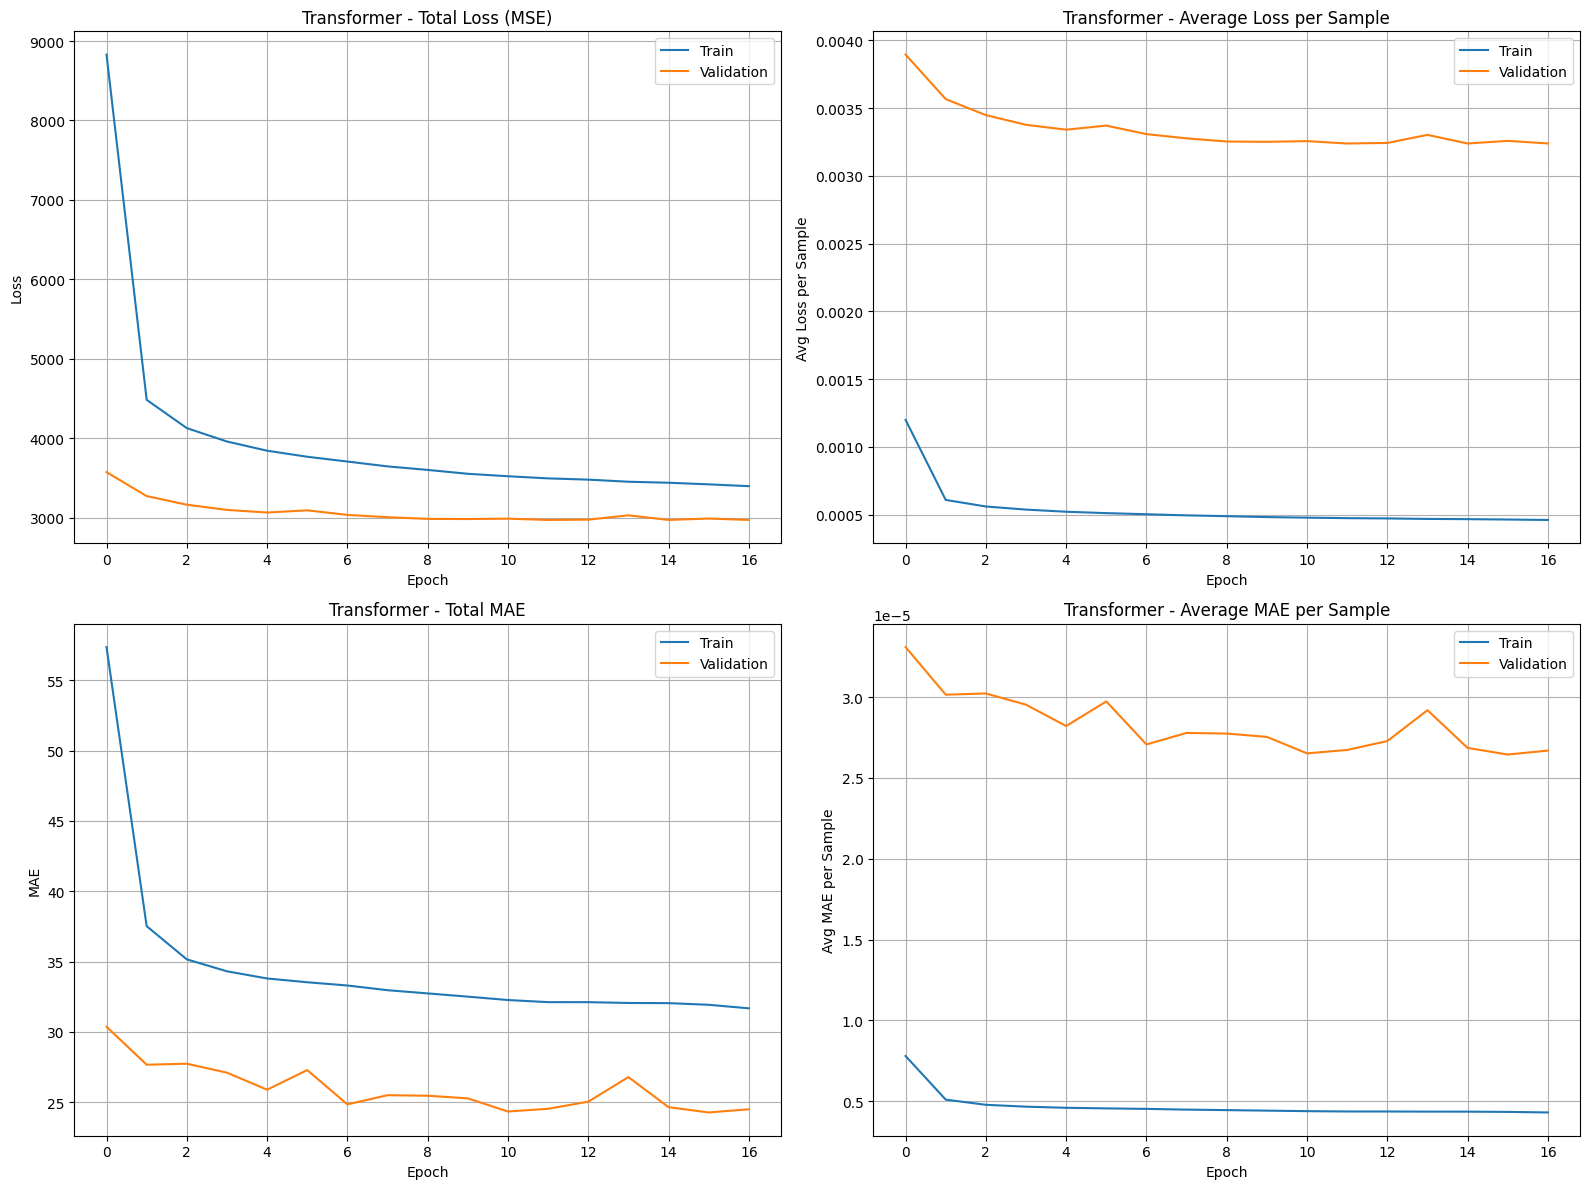


Evaluating Transformer model on test set...



Transformer - Test Evaluation Metrics:
  Overall:  MSE: 2816.77, RMSE: 53.07, MAE: 24.26, R²: 0.9696, MASE: 0.48
  Daytime:  MSE: 5653.55, RMSE: 75.19, MAE: 47.85, R²: 0.9313, MASE: 0.47
  Nighttime: MSE: 0.93, RMSE: 0.96, MAE: 0.84, R²: 0.6449, MASE: 8.24
  Inference Speed: 8863261.78 samples/sec, 0.1128 μs/sample
  Total time: 0.1038 sec for 919800 samples
Model saved to checkpoints/Transformer_best_20250507_041527.pt with metadata.
Best model saved to checkpoints/Transformer_best_20250507_041527.pt
Saved model checkpoint logged to wandb: checkpoints/Transformer_best_20250507_041527.pt


test/inference_speed_samples_per_sec,▁
test/inference_time_us_per_sample,▁
test/mae,▁
test/mase,▁
test/mse,▁
test/r2,▁
test/rmse,▁
train/epoch,▁▁▂▂▃▃▄▄▅▅▅▆▆▇▇██
train/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train/loss,█▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁
train/mae,█▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁


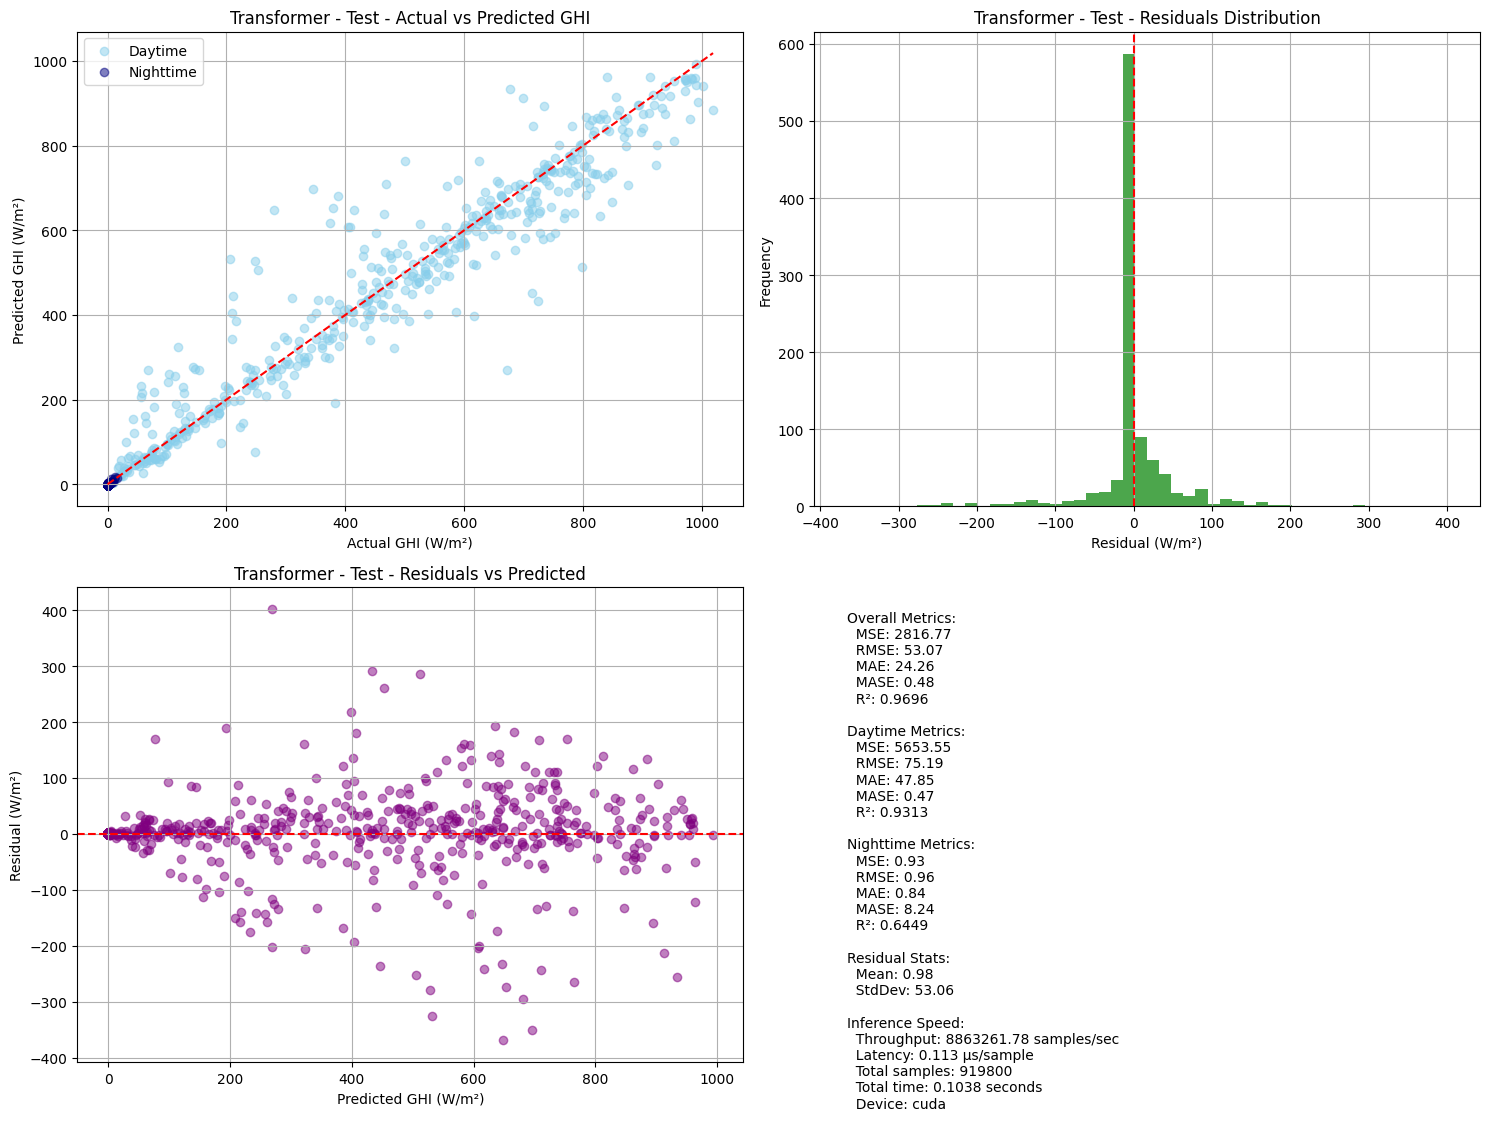

In [9]:
model_name = "Transformer"

# Train the Transformer model
transformer_history, transformer_val_metrics, transformer_test_metrics = run_experiment_pipeline(
    transformer_model,
    train_loader,
    val_loader,
    test_loader,
    model_name=model_name,
    epochs=N_EPOCHS,
    patience=PATIENCE,
    lr=LR
)

### 3.2 Informer Model

The Informer model is a recent advancement in time series forecasting that addresses the computational limitations of standard Transformer models for long sequence prediction. Key innovations include:

- **ProbSparse Self-attention**: Reduces complexity from O(L²) to O(L log L) where L is sequence length.
- **Self-attention Distilling**: Progressive downsampling of hidden states along the encoder.
- **Generative Decoder**: Enables long sequence prediction with minimal compute.

For solar radiation forecasting, Informer can efficiently capture daily, weekly, and seasonal patterns while focusing computational resources on the most informative timestamps.

For detailed model code: `models/informer.py`

In [10]:
from models.informer import InformerModel

# Create Informer model
informer_model = InformerModel(
    input_dim=temporal_dim,
    static_dim=static_dim,
    d_model=128,
    n_heads=4,
    e_layers=2,
    d_ff=256,
    dropout=0.1,
    activation='gelu',
).to(device)

# Print the model
print_model_info(informer_model, temporal_features.shape, static_features.shape)

Error generating model summary: Failed to run torchinfo. See above stack traces for more details. Executed layers up to: []
Model: InformerModel
Total parameters: 334,977
Trainable parameters: 334,977
Non-trainable parameters: 0

Model structure:
InformerModel(
  (enc_embedding): TokenEmbedding(
    (tokenConv): Conv1d(19, 128, kernel_size=(3,), stride=(1,), padding=(1,), bias=False)
  )
  (pos_encoder): PositionalEncoding()
  (encoder): Encoder(
    (attn_layers): ModuleList(
      (0-1): 2 x EncoderLayer(
        (attention): AttentionLayer(
          (inner_attention): ProbAttention(
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (query_projection): Linear(in_features=128, out_features=128, bias=True)
          (key_projection): Linear(in_features=128, out_features=128, bias=True)
          (value_projection): Linear(in_features=128, out_features=128, bias=True)
          (out_projection): Linear(in_features=128, out_features=128, bias=True)
        )
   

Training Informer model...
track_experiment: USE_WANDB=True, wandb.run=None, keep_run_open=True
Error generating model summary: Failed to run torchinfo. See above stack traces for more details. Executed layers up to: []
Creating new wandb run for Informer


Training config: {'DEBUG_MODE': False, 'PATIENCE': 5, 'LR': 0.0001, 'N_EPOCHS': 30, 'BATCH_SIZE': 8192, 'NUM_WORKERS': 16, 'USE_WANDB': True, 'WANDB_USERNAME': 'tin-hoang', 'WANDB_PROJECT': 'EEEM073-Solar-Radiation', 'LOOKBACK': 24, 'TIME_FEATURES': ['hour_sin', 'hour_cos', 'day_sin', 'day_cos', 'month_sin', 'month_cos', 'dow_sin', 'dow_cos'], 'SELECTED_FEATURES': ['air_temperature', 'wind_speed', 'relative_humidity', 'cloud_type', 'solar_zenith_angle', 'clearsky_ghi', 'total_precipitable_water', 'surface_albedo', 'nighttime_mask', 'cld_opd_dcomp', 'aod'], 'STATIC_FEATURES': ['latitude', 'longitude', 'elevation'], 'TARGET_VARIABLE': 'ghi', 'TRAIN_PREPROCESSED_DATA_PATH': 'data/processed/train_normalized_20250430_145157.h5', 'VAL_PREPROCESSED_DATA_PATH': 'data/processed/val_normalized_20250430_145205.h5', 'TEST_PREPROCESSED_DATA_PATH': 'data/processed/test_normalized_20250430_145205.h5', 'SCALER_PATH': 'data/processed/scalers_20250430_145206.pkl', 'TEMPORAL_FEATURES_SHAPE': [8192, 24, 1


Validation Informer (Epoch 1) Evaluation Metrics:
  Overall:  MSE: 3691.46, RMSE: 60.76, MAE: 31.43, R²: 0.9597, MASE: 0.67
  Daytime:  MSE: 7365.54, RMSE: 85.82, MAE: 58.12, R²: 0.9078, MASE: 0.61
  Nighttime: MSE: 44.21, RMSE: 6.65, MAE: 4.93, R²: -15.5398, MASE: 47.88
  Inference Speed: 3340558.40 samples/sec, 0.2994 μs/sample
  Total time: 0.2746 sec for 917280 samples
Epoch 1/30 | Train Loss: 10581.6631, Train MAE: 64.5317 | Val Loss: 3691.4563, Val MAE: 31.4271 | LR: 0.000100



Validation Informer (Epoch 2) Evaluation Metrics:
  Overall:  MSE: 3372.69, RMSE: 58.07, MAE: 27.71, R²: 0.9632, MASE: 0.59
  Daytime:  MSE: 6759.17, RMSE: 82.21, MAE: 53.23, R²: 0.9154, MASE: 0.56
  Nighttime: MSE: 10.95, RMSE: 3.31, MAE: 2.37, R²: -3.0951, MASE: 23.02
  Inference Speed: 4031341.60 samples/sec, 0.2481 μs/sample
  Total time: 0.2275 sec for 917280 samples
Epoch 2/30 | Train Loss: 4659.6792, Train MAE: 37.8811 | Val Loss: 3372.6877, Val MAE: 27.7087 | LR: 0.000100



Validation Informer (Epoch 3) Evaluation Metrics:
  Overall:  MSE: 3184.32, RMSE: 56.43, MAE: 27.23, R²: 0.9653, MASE: 0.58
  Daytime:  MSE: 6383.35, RMSE: 79.90, MAE: 52.36, R²: 0.9201, MASE: 0.55
  Nighttime: MSE: 8.66, RMSE: 2.94, MAE: 2.28, R²: -2.2399, MASE: 22.11
  Inference Speed: 3810194.16 samples/sec, 0.2625 μs/sample
  Total time: 0.2407 sec for 917280 samples
Epoch 3/30 | Train Loss: 4193.6392, Train MAE: 34.2962 | Val Loss: 3184.3196, Val MAE: 27.2252 | LR: 0.000100



Validation Informer (Epoch 4) Evaluation Metrics:
  Overall:  MSE: 3095.27, RMSE: 55.64, MAE: 26.41, R²: 0.9662, MASE: 0.56
  Daytime:  MSE: 6205.96, RMSE: 78.78, MAE: 50.97, R²: 0.9223, MASE: 0.54
  Nighttime: MSE: 7.30, RMSE: 2.70, MAE: 2.03, R²: -1.7318, MASE: 19.69
  Inference Speed: 3668192.96 samples/sec, 0.2726 μs/sample
  Total time: 0.2501 sec for 917280 samples
Epoch 4/30 | Train Loss: 3986.2424, Train MAE: 32.7994 | Val Loss: 3095.2700, Val MAE: 26.4112 | LR: 0.000100



Validation Informer (Epoch 5) Evaluation Metrics:
  Overall:  MSE: 3066.26, RMSE: 55.37, MAE: 26.93, R²: 0.9665, MASE: 0.57
  Daytime:  MSE: 6146.15, RMSE: 78.40, MAE: 51.79, R²: 0.9230, MASE: 0.55
  Nighttime: MSE: 8.86, RMSE: 2.98, MAE: 2.25, R²: -2.3162, MASE: 21.86
  Inference Speed: 3632839.28 samples/sec, 0.2753 μs/sample
  Total time: 0.2525 sec for 917280 samples
Epoch 5/30 | Train Loss: 3861.9170, Train MAE: 32.0583 | Val Loss: 3066.2571, Val MAE: 26.9324 | LR: 0.000100



Validation Informer (Epoch 6) Evaluation Metrics:
  Overall:  MSE: 3030.81, RMSE: 55.05, MAE: 25.68, R²: 0.9669, MASE: 0.54
  Daytime:  MSE: 6076.14, RMSE: 77.95, MAE: 49.33, R²: 0.9239, MASE: 0.52
  Nighttime: MSE: 7.71, RMSE: 2.78, MAE: 2.21, R²: -1.8844, MASE: 21.46
  Inference Speed: 3734922.53 samples/sec, 0.2677 μs/sample
  Total time: 0.2456 sec for 917280 samples
Epoch 6/30 | Train Loss: 3762.9224, Train MAE: 31.5180 | Val Loss: 3030.8054, Val MAE: 25.6811 | LR: 0.000100



Validation Informer (Epoch 7) Evaluation Metrics:
  Overall:  MSE: 3040.33, RMSE: 55.14, MAE: 26.41, R²: 0.9668, MASE: 0.56
  Daytime:  MSE: 6097.90, RMSE: 78.09, MAE: 51.24, R²: 0.9236, MASE: 0.54
  Nighttime: MSE: 5.10, RMSE: 2.26, MAE: 1.77, R²: -0.9071, MASE: 17.20
  Inference Speed: 3852791.31 samples/sec, 0.2596 μs/sample
  Total time: 0.2381 sec for 917280 samples
Epoch 7/30 | Train Loss: 3701.0605, Train MAE: 31.2869 | Val Loss: 3040.3323, Val MAE: 26.4142 | LR: 0.000100



Validation Informer (Epoch 8) Evaluation Metrics:
  Overall:  MSE: 3035.47, RMSE: 55.10, MAE: 26.55, R²: 0.9669, MASE: 0.56
  Daytime:  MSE: 6088.70, RMSE: 78.03, MAE: 51.71, R²: 0.9238, MASE: 0.55
  Nighttime: MSE: 4.53, RMSE: 2.13, MAE: 1.58, R²: -0.6966, MASE: 15.31
  Inference Speed: 3493529.95 samples/sec, 0.2862 μs/sample
  Total time: 0.2626 sec for 917280 samples
Epoch 8/30 | Train Loss: 3648.4890, Train MAE: 31.2724 | Val Loss: 3035.4695, Val MAE: 26.5511 | LR: 0.000100



Validation Informer (Epoch 9) Evaluation Metrics:
  Overall:  MSE: 3022.29, RMSE: 54.98, MAE: 26.00, R²: 0.9670, MASE: 0.55
  Daytime:  MSE: 6062.76, RMSE: 77.86, MAE: 50.76, R²: 0.9241, MASE: 0.54
  Nighttime: MSE: 4.02, RMSE: 2.01, MAE: 1.42, R²: -0.5056, MASE: 13.75
  Inference Speed: 3551716.91 samples/sec, 0.2816 μs/sample
  Total time: 0.2583 sec for 917280 samples
Epoch 9/30 | Train Loss: 3607.2993, Train MAE: 31.2808 | Val Loss: 3022.2913, Val MAE: 25.9974 | LR: 0.000100



Validation Informer (Epoch 10) Evaluation Metrics:
  Overall:  MSE: 3001.84, RMSE: 54.79, MAE: 25.38, R²: 0.9672, MASE: 0.54
  Daytime:  MSE: 6022.31, RMSE: 77.60, MAE: 49.60, R²: 0.9246, MASE: 0.52
  Nighttime: MSE: 3.43, RMSE: 1.85, MAE: 1.33, R²: -0.2843, MASE: 12.88
  Inference Speed: 3680393.79 samples/sec, 0.2717 μs/sample
  Total time: 0.2492 sec for 917280 samples
Epoch 10/30 | Train Loss: 3566.6658, Train MAE: 31.3164 | Val Loss: 3001.8428, Val MAE: 25.3769 | LR: 0.000100



Validation Informer (Epoch 11) Evaluation Metrics:
  Overall:  MSE: 2990.81, RMSE: 54.69, MAE: 25.18, R²: 0.9674, MASE: 0.53
  Daytime:  MSE: 5997.80, RMSE: 77.45, MAE: 48.69, R²: 0.9249, MASE: 0.51
  Nighttime: MSE: 5.78, RMSE: 2.40, MAE: 1.84, R²: -1.1613, MASE: 17.83
  Inference Speed: 3732473.12 samples/sec, 0.2679 μs/sample
  Total time: 0.2458 sec for 917280 samples
Epoch 11/30 | Train Loss: 3533.8413, Train MAE: 31.3762 | Val Loss: 2990.8091, Val MAE: 25.1798 | LR: 0.000100



Validation Informer (Epoch 12) Evaluation Metrics:
  Overall:  MSE: 2985.05, RMSE: 54.64, MAE: 25.26, R²: 0.9674, MASE: 0.53
  Daytime:  MSE: 5987.38, RMSE: 77.38, MAE: 49.02, R²: 0.9250, MASE: 0.52
  Nighttime: MSE: 4.65, RMSE: 2.16, MAE: 1.67, R²: -0.7383, MASE: 16.25
  Inference Speed: 3619050.60 samples/sec, 0.2763 μs/sample
  Total time: 0.2535 sec for 917280 samples
Epoch 12/30 | Train Loss: 3498.5405, Train MAE: 31.2537 | Val Loss: 2985.0505, Val MAE: 25.2612 | LR: 0.000100



Validation Informer (Epoch 13) Evaluation Metrics:
  Overall:  MSE: 2992.85, RMSE: 54.71, MAE: 25.56, R²: 0.9673, MASE: 0.54
  Daytime:  MSE: 6005.32, RMSE: 77.49, MAE: 50.10, R²: 0.9248, MASE: 0.53
  Nighttime: MSE: 2.38, RMSE: 1.54, MAE: 1.20, R²: 0.1088, MASE: 11.65
  Inference Speed: 3979206.15 samples/sec, 0.2513 μs/sample
  Total time: 0.2305 sec for 917280 samples
Epoch 13/30 | Train Loss: 3459.7058, Train MAE: 31.0263 | Val Loss: 2992.8508, Val MAE: 25.5604 | LR: 0.000100



Validation Informer (Epoch 14) Evaluation Metrics:
  Overall:  MSE: 2979.29, RMSE: 54.58, MAE: 24.77, R²: 0.9675, MASE: 0.52
  Daytime:  MSE: 5977.86, RMSE: 77.32, MAE: 48.59, R²: 0.9252, MASE: 0.51
  Nighttime: MSE: 2.63, RMSE: 1.62, MAE: 1.12, R²: 0.0164, MASE: 10.87
  Inference Speed: 3566248.75 samples/sec, 0.2804 μs/sample
  Total time: 0.2572 sec for 917280 samples
Epoch 14/30 | Train Loss: 3428.0151, Train MAE: 30.9174 | Val Loss: 2979.2920, Val MAE: 24.7666 | LR: 0.000100



Validation Informer (Epoch 15) Evaluation Metrics:
  Overall:  MSE: 3006.35, RMSE: 54.83, MAE: 25.84, R²: 0.9672, MASE: 0.55
  Daytime:  MSE: 6032.34, RMSE: 77.67, MAE: 50.60, R²: 0.9245, MASE: 0.53
  Nighttime: MSE: 2.47, RMSE: 1.57, MAE: 1.27, R²: 0.0760, MASE: 12.30
  Inference Speed: 3706214.81 samples/sec, 0.2698 μs/sample
  Total time: 0.2475 sec for 917280 samples
Epoch 15/30 | Train Loss: 3400.6648, Train MAE: 30.8997 | Val Loss: 3006.3523, Val MAE: 25.8436 | LR: 0.000100



Validation Informer (Epoch 16) Evaluation Metrics:
  Overall:  MSE: 2964.21, RMSE: 54.44, MAE: 24.75, R²: 0.9677, MASE: 0.52
  Daytime:  MSE: 5948.32, RMSE: 77.13, MAE: 48.70, R²: 0.9255, MASE: 0.51
  Nighttime: MSE: 1.90, RMSE: 1.38, MAE: 0.98, R²: 0.2891, MASE: 9.48
  Inference Speed: 3836754.06 samples/sec, 0.2606 μs/sample
  Total time: 0.2391 sec for 917280 samples
Epoch 16/30 | Train Loss: 3367.3750, Train MAE: 30.8794 | Val Loss: 2964.2131, Val MAE: 24.7496 | LR: 0.000100



Validation Informer (Epoch 17) Evaluation Metrics:
  Overall:  MSE: 2962.41, RMSE: 54.43, MAE: 24.93, R²: 0.9677, MASE: 0.53
  Daytime:  MSE: 5944.61, RMSE: 77.10, MAE: 48.97, R²: 0.9256, MASE: 0.52
  Nighttime: MSE: 2.00, RMSE: 1.41, MAE: 1.07, R²: 0.2523, MASE: 10.42
  Inference Speed: 3837308.94 samples/sec, 0.2606 μs/sample
  Total time: 0.2390 sec for 917280 samples
Epoch 17/30 | Train Loss: 3345.3569, Train MAE: 30.8846 | Val Loss: 2962.4116, Val MAE: 24.9335 | LR: 0.000100



Validation Informer (Epoch 18) Evaluation Metrics:
  Overall:  MSE: 2996.79, RMSE: 54.74, MAE: 25.49, R²: 0.9673, MASE: 0.54
  Daytime:  MSE: 6014.30, RMSE: 77.55, MAE: 50.35, R²: 0.9247, MASE: 0.53
  Nighttime: MSE: 1.32, RMSE: 1.15, MAE: 0.81, R²: 0.5047, MASE: 7.87
  Inference Speed: 3696273.39 samples/sec, 0.2705 μs/sample
  Total time: 0.2482 sec for 917280 samples
Epoch 18/30 | Train Loss: 3314.3237, Train MAE: 30.6931 | Val Loss: 2996.7920, Val MAE: 25.4902 | LR: 0.000100



Validation Informer (Epoch 19) Evaluation Metrics:
  Overall:  MSE: 2986.18, RMSE: 54.65, MAE: 24.97, R²: 0.9674, MASE: 0.53
  Daytime:  MSE: 5992.85, RMSE: 77.41, MAE: 49.25, R²: 0.9250, MASE: 0.52
  Nighttime: MSE: 1.46, RMSE: 1.21, MAE: 0.88, R²: 0.4531, MASE: 8.54
  Inference Speed: 3701732.42 samples/sec, 0.2701 μs/sample
  Total time: 0.2478 sec for 917280 samples
Epoch 19/30 | Train Loss: 3281.3721, Train MAE: 30.4786 | Val Loss: 2986.1763, Val MAE: 24.9748 | LR: 0.000100



Validation Informer (Epoch 20) Evaluation Metrics:
  Overall:  MSE: 2986.12, RMSE: 54.65, MAE: 25.67, R²: 0.9674, MASE: 0.54
  Daytime:  MSE: 5992.56, RMSE: 77.41, MAE: 50.49, R²: 0.9250, MASE: 0.53
  Nighttime: MSE: 1.65, RMSE: 1.28, MAE: 1.02, R²: 0.3845, MASE: 9.94
  Inference Speed: 4094473.10 samples/sec, 0.2442 μs/sample
  Total time: 0.2240 sec for 917280 samples
Epoch 20/30 | Train Loss: 3256.2219, Train MAE: 30.3928 | Val Loss: 2986.1213, Val MAE: 25.6669 | LR: 0.000100



Validation Informer (Epoch 21) Evaluation Metrics:
  Overall:  MSE: 2977.51, RMSE: 54.57, MAE: 25.11, R²: 0.9675, MASE: 0.53
  Daytime:  MSE: 5975.66, RMSE: 77.30, MAE: 49.61, R²: 0.9252, MASE: 0.52
  Nighttime: MSE: 1.26, RMSE: 1.12, MAE: 0.79, R²: 0.5289, MASE: 7.68
  Inference Speed: 3876389.20 samples/sec, 0.2580 μs/sample
  Total time: 0.2366 sec for 917280 samples
Epoch 21/30 | Train Loss: 3236.5359, Train MAE: 30.4750 | Val Loss: 2977.5103, Val MAE: 25.1134 | LR: 0.000100



Validation Informer (Epoch 22) Evaluation Metrics:
  Overall:  MSE: 2969.70, RMSE: 54.49, MAE: 25.27, R²: 0.9676, MASE: 0.53
  Daytime:  MSE: 5959.10, RMSE: 77.20, MAE: 49.48, R²: 0.9254, MASE: 0.52
  Nighttime: MSE: 2.13, RMSE: 1.46, MAE: 1.23, R²: 0.2022, MASE: 11.94
  Inference Speed: 3600901.85 samples/sec, 0.2777 μs/sample
  Total time: 0.2547 sec for 917280 samples
Epoch 22/30 | Train Loss: 3210.1885, Train MAE: 30.4518 | Val Loss: 2969.7019, Val MAE: 25.2667 | LR: 0.000100
Early stopping at epoch 22
Loading best model from training session. The model object now can be used to make predictions.
Keeping wandb run open as requested (keep_run_open=True)


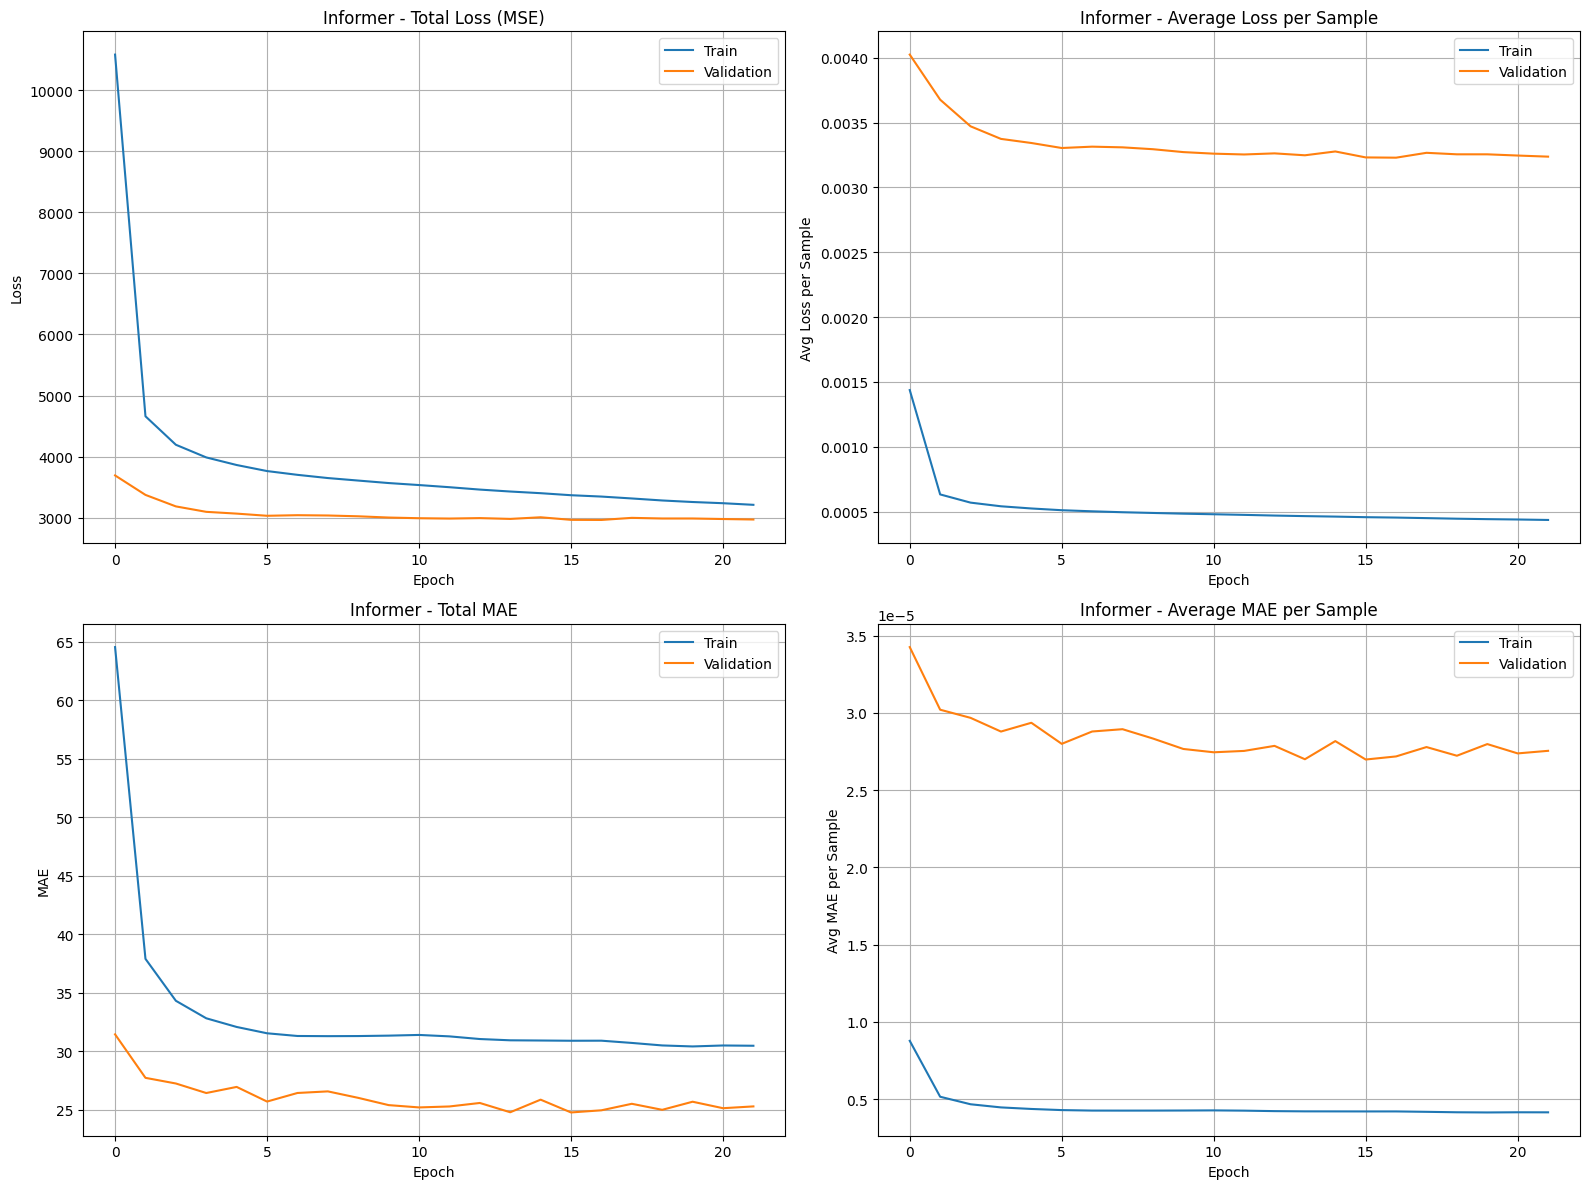


Evaluating Informer model on test set...



Informer - Test Evaluation Metrics:
  Overall:  MSE: 2848.56, RMSE: 53.37, MAE: 25.11, R²: 0.9692, MASE: 0.50
  Daytime:  MSE: 5716.24, RMSE: 75.61, MAE: 49.23, R²: 0.9306, MASE: 0.49
  Nighttime: MSE: 2.05, RMSE: 1.43, MAE: 1.18, R²: 0.2128, MASE: 11.58
  Inference Speed: 3750593.83 samples/sec, 0.2666 μs/sample
  Total time: 0.2452 sec for 919800 samples
Model saved to checkpoints/Informer_best_20250507_053404.pt with metadata.
Best model saved to checkpoints/Informer_best_20250507_053404.pt
Saved model checkpoint logged to wandb: checkpoints/Informer_best_20250507_053404.pt


test/inference_speed_samples_per_sec,▁
test/inference_time_us_per_sample,▁
test/mae,▁
test/mase,▁
test/mse,▁
test/r2,▁
test/rmse,▁
train/epoch,▁▁▂▂▂▃▃▃▄▄▄▅▅▅▆▆▆▇▇▇██
train/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train/loss,█▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train/mae,█▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁


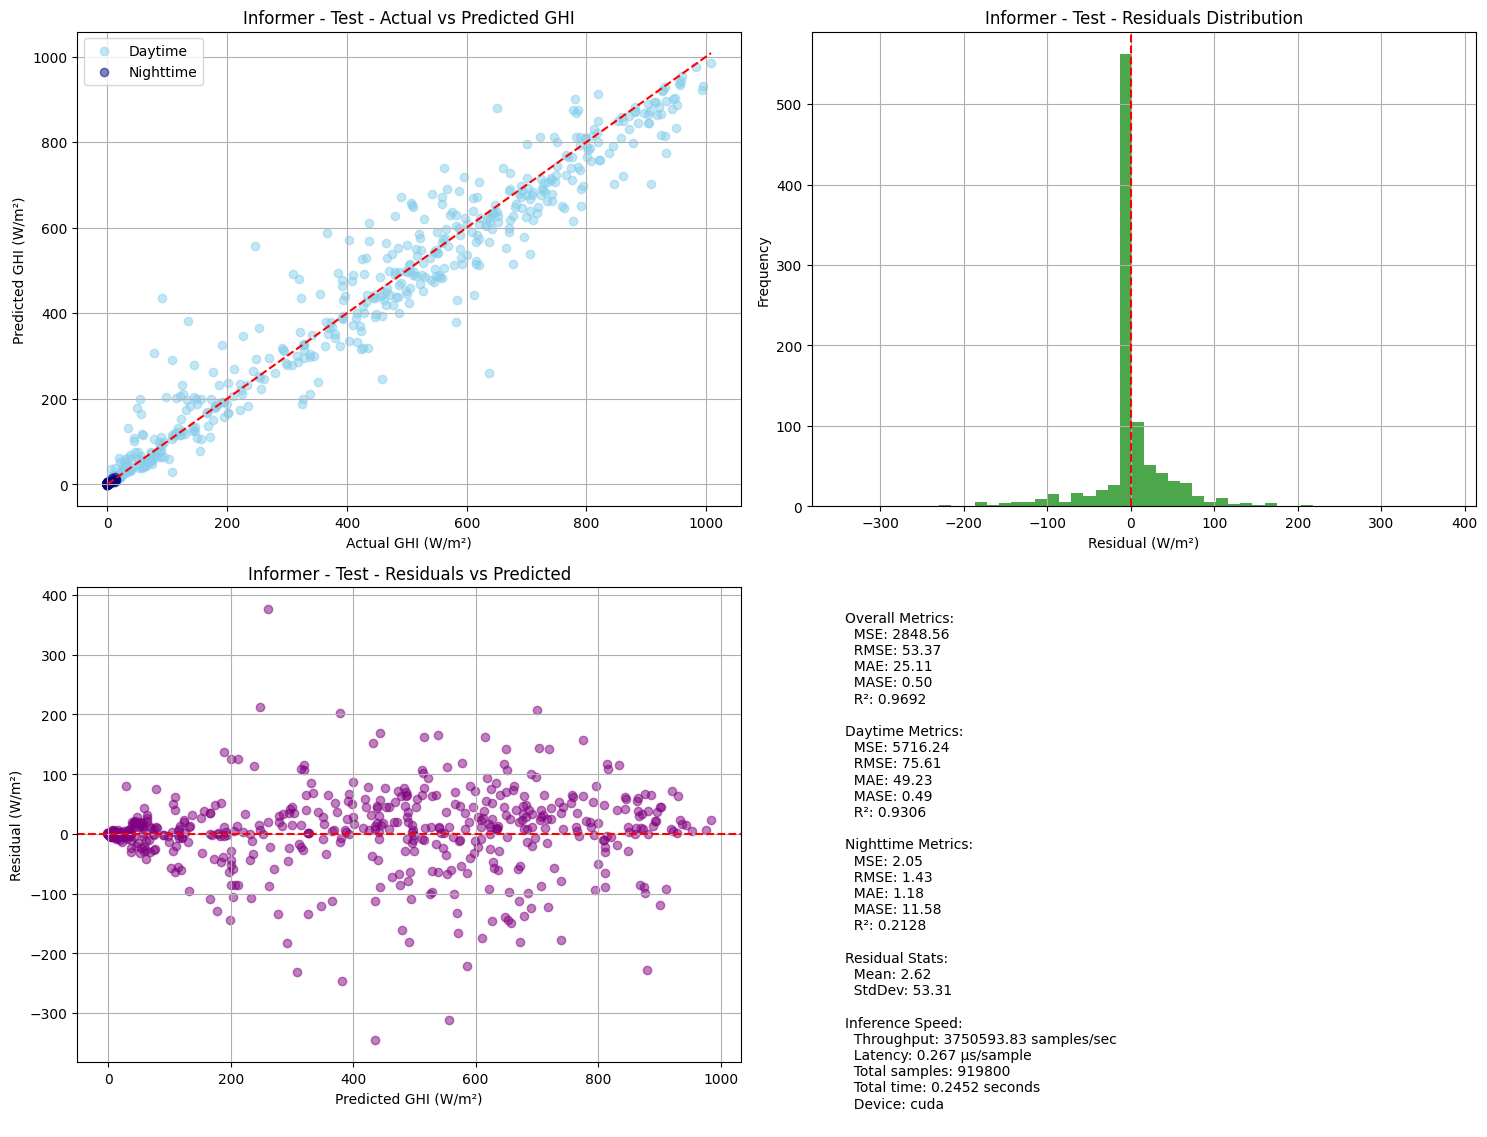

In [11]:
model_name = "Informer"

# Train the Informer model with a lower learning rate
informer_history, informer_val_metrics, informer_test_metrics = run_experiment_pipeline(
    informer_model,
    train_loader,
    val_loader,
    test_loader,
    model_name=model_name,
    epochs=N_EPOCHS,
    patience=PATIENCE,
    lr=LR
)

### 3.3 TSMixer Model

TSMixer is a simple yet effective architecture for time series forecasting that applies the ideas of MLP-Mixer to time series data:

- **Separate time and feature mixing**: Processes temporal and feature dimensions separately
- **Parameter efficiency**: Uses simple MLP blocks to mix information across dimensions
- **Fast training**: Simple architecture allows for efficient training

For detailed model code: `models/tsmixer.py`

In [12]:
from models.tsmixer import TSMixerModel

# Create TSMixer model
tsmixer_model = TSMixerModel(
    input_dim=temporal_dim,
    static_dim=static_dim,
    lookback=LOOKBACK,
    horizon=1,             # Single-step prediction
    ff_dim=256,            # Feed-forward dimension
    num_blocks=10,          # Number of TSMixer blocks
    norm_type='batch',
    activation='relu',
    dropout=0.1
).to(device)

# Print the model
print_model_info(tsmixer_model, temporal_features.shape, static_features.shape)

Error generating model summary: Failed to run torchinfo. See above stack traces for more details. Executed layers up to: []
Model: TSMixerModel
Total parameters: 109,823
Trainable parameters: 109,823
Non-trainable parameters: 0

Model structure:
TSMixerModel(
  (tsmixer): TSMixer(
    (mixer_layers): Sequential(
      (0): MixerLayer(
        (time_mixing): TimeMixing(
          (norm): TimeBatchNorm2d(456, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (dropout): Dropout(p=0.1, inplace=False)
          (fc1): Linear(in_features=24, out_features=24, bias=True)
        )
        (feature_mixing): FeatureMixing(
          (norm_before): TimeBatchNorm2d(456, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (norm_after): Identity()
          (dropout): Dropout(p=0.1, inplace=False)
          (fc1): Linear(in_features=19, out_features=256, bias=True)
          (fc2): Linear(in_features=256, out_features=19, bias=True)
          (projection

Training TSMixer model...
track_experiment: USE_WANDB=True, wandb.run=None, keep_run_open=True
Error generating model summary: Failed to run torchinfo. See above stack traces for more details. Executed layers up to: []
Creating new wandb run for TSMixer


Training config: {'DEBUG_MODE': False, 'PATIENCE': 5, 'LR': 0.0001, 'N_EPOCHS': 30, 'BATCH_SIZE': 8192, 'NUM_WORKERS': 16, 'USE_WANDB': True, 'WANDB_USERNAME': 'tin-hoang', 'WANDB_PROJECT': 'EEEM073-Solar-Radiation', 'LOOKBACK': 24, 'TIME_FEATURES': ['hour_sin', 'hour_cos', 'day_sin', 'day_cos', 'month_sin', 'month_cos', 'dow_sin', 'dow_cos'], 'SELECTED_FEATURES': ['air_temperature', 'wind_speed', 'relative_humidity', 'cloud_type', 'solar_zenith_angle', 'clearsky_ghi', 'total_precipitable_water', 'surface_albedo', 'nighttime_mask', 'cld_opd_dcomp', 'aod'], 'STATIC_FEATURES': ['latitude', 'longitude', 'elevation'], 'TARGET_VARIABLE': 'ghi', 'TRAIN_PREPROCESSED_DATA_PATH': 'data/processed/train_normalized_20250430_145157.h5', 'VAL_PREPROCESSED_DATA_PATH': 'data/processed/val_normalized_20250430_145205.h5', 'TEST_PREPROCESSED_DATA_PATH': 'data/processed/test_normalized_20250430_145205.h5', 'SCALER_PATH': 'data/processed/scalers_20250430_145206.pkl', 'TEMPORAL_FEATURES_SHAPE': [8192, 24, 1


Validation TSMixer (Epoch 1) Evaluation Metrics:
  Overall:  MSE: 3685.80, RMSE: 60.71, MAE: 33.84, R²: 0.9598, MASE: 0.72
  Daytime:  MSE: 7191.05, RMSE: 84.80, MAE: 56.55, R²: 0.9100, MASE: 0.60
  Nighttime: MSE: 206.15, RMSE: 14.36, MAE: 11.29, R²: -76.1313, MASE: 109.64
  Inference Speed: 4922523.93 samples/sec, 0.2031 μs/sample
  Total time: 0.1863 sec for 917280 samples
Epoch 1/30 | Train Loss: 30292.9512, Train MAE: 118.6539 | Val Loss: 3685.7993, Val MAE: 33.8385 | LR: 0.000100



Validation TSMixer (Epoch 2) Evaluation Metrics:
  Overall:  MSE: 3274.94, RMSE: 57.23, MAE: 29.75, R²: 0.9643, MASE: 0.63
  Daytime:  MSE: 6485.28, RMSE: 80.53, MAE: 52.32, R²: 0.9188, MASE: 0.55
  Nighttime: MSE: 88.05, RMSE: 9.38, MAE: 7.34, R²: -31.9432, MASE: 71.28
  Inference Speed: 4707737.23 samples/sec, 0.2124 μs/sample
  Total time: 0.1948 sec for 917280 samples
Epoch 2/30 | Train Loss: 9576.9873, Train MAE: 64.6542 | Val Loss: 3274.9402, Val MAE: 29.7458 | LR: 0.000100



Validation TSMixer (Epoch 3) Evaluation Metrics:
  Overall:  MSE: 3249.04, RMSE: 57.00, MAE: 27.81, R²: 0.9645, MASE: 0.59
  Daytime:  MSE: 6488.28, RMSE: 80.55, MAE: 51.39, R²: 0.9188, MASE: 0.54
  Nighttime: MSE: 33.46, RMSE: 5.78, MAE: 4.41, R²: -11.5187, MASE: 42.82
  Inference Speed: 4930643.03 samples/sec, 0.2028 μs/sample
  Total time: 0.1860 sec for 917280 samples
Epoch 3/30 | Train Loss: 5394.0518, Train MAE: 43.6568 | Val Loss: 3249.0393, Val MAE: 27.8115 | LR: 0.000100



Validation TSMixer (Epoch 4) Evaluation Metrics:
  Overall:  MSE: 3198.01, RMSE: 56.55, MAE: 26.30, R²: 0.9651, MASE: 0.56
  Daytime:  MSE: 6405.43, RMSE: 80.03, MAE: 50.24, R²: 0.9198, MASE: 0.53
  Nighttime: MSE: 14.02, RMSE: 3.74, MAE: 2.53, R²: -4.2439, MASE: 24.60
  Inference Speed: 5215898.66 samples/sec, 0.1917 μs/sample
  Total time: 0.1759 sec for 917280 samples
Epoch 4/30 | Train Loss: 4230.0298, Train MAE: 35.0817 | Val Loss: 3198.0120, Val MAE: 26.2982 | LR: 0.000100



Validation TSMixer (Epoch 5) Evaluation Metrics:
  Overall:  MSE: 3036.68, RMSE: 55.11, MAE: 25.40, R²: 0.9669, MASE: 0.54
  Daytime:  MSE: 6086.58, RMSE: 78.02, MAE: 49.02, R²: 0.9238, MASE: 0.52
  Nighttime: MSE: 9.06, RMSE: 3.01, MAE: 1.95, R²: -2.3887, MASE: 18.95
  Inference Speed: 4953082.20 samples/sec, 0.2019 μs/sample
  Total time: 0.1852 sec for 917280 samples
Epoch 5/30 | Train Loss: 3861.0581, Train MAE: 31.9803 | Val Loss: 3036.6838, Val MAE: 25.4019 | LR: 0.000100



Validation TSMixer (Epoch 6) Evaluation Metrics:
  Overall:  MSE: 3023.34, RMSE: 54.98, MAE: 25.15, R²: 0.9670, MASE: 0.53
  Daytime:  MSE: 6060.80, RMSE: 77.85, MAE: 48.21, R²: 0.9241, MASE: 0.51
  Nighttime: MSE: 8.07, RMSE: 2.84, MAE: 2.26, R²: -2.0177, MASE: 21.94
  Inference Speed: 4655268.34 samples/sec, 0.2148 μs/sample
  Total time: 0.1970 sec for 917280 samples
Epoch 6/30 | Train Loss: 3703.4934, Train MAE: 30.7727 | Val Loss: 3023.3416, Val MAE: 25.1519 | LR: 0.000100



Validation TSMixer (Epoch 7) Evaluation Metrics:
  Overall:  MSE: 2985.95, RMSE: 54.64, MAE: 25.44, R²: 0.9674, MASE: 0.54
  Daytime:  MSE: 5986.72, RMSE: 77.37, MAE: 48.84, R²: 0.9250, MASE: 0.52
  Nighttime: MSE: 7.10, RMSE: 2.67, MAE: 2.21, R²: -1.6577, MASE: 21.43
  Inference Speed: 4842249.42 samples/sec, 0.2065 μs/sample
  Total time: 0.1894 sec for 917280 samples
Epoch 7/30 | Train Loss: 3615.5081, Train MAE: 30.1776 | Val Loss: 2985.9536, Val MAE: 25.4368 | LR: 0.000100



Validation TSMixer (Epoch 8) Evaluation Metrics:
  Overall:  MSE: 2967.73, RMSE: 54.48, MAE: 25.46, R²: 0.9676, MASE: 0.54
  Daytime:  MSE: 5948.87, RMSE: 77.13, MAE: 48.66, R²: 0.9255, MASE: 0.51
  Nighttime: MSE: 8.35, RMSE: 2.89, MAE: 2.44, R²: -2.1248, MASE: 23.67
  Inference Speed: 4933374.33 samples/sec, 0.2027 μs/sample
  Total time: 0.1859 sec for 917280 samples
Epoch 8/30 | Train Loss: 3551.5068, Train MAE: 29.7590 | Val Loss: 2967.7273, Val MAE: 25.4640 | LR: 0.000100



Validation TSMixer (Epoch 9) Evaluation Metrics:
  Overall:  MSE: 2949.18, RMSE: 54.31, MAE: 25.64, R²: 0.9678, MASE: 0.54
  Daytime:  MSE: 5910.78, RMSE: 76.88, MAE: 48.94, R²: 0.9260, MASE: 0.52
  Nighttime: MSE: 9.21, RMSE: 3.03, MAE: 2.52, R²: -2.4458, MASE: 24.48
  Inference Speed: 4781361.44 samples/sec, 0.2091 μs/sample
  Total time: 0.1918 sec for 917280 samples
Epoch 9/30 | Train Loss: 3510.8062, Train MAE: 29.5140 | Val Loss: 2949.1814, Val MAE: 25.6441 | LR: 0.000100



Validation TSMixer (Epoch 10) Evaluation Metrics:
  Overall:  MSE: 2964.04, RMSE: 54.44, MAE: 25.30, R²: 0.9677, MASE: 0.54
  Daytime:  MSE: 5939.42, RMSE: 77.07, MAE: 48.10, R²: 0.9256, MASE: 0.51
  Nighttime: MSE: 10.40, RMSE: 3.22, MAE: 2.67, R²: -2.8902, MASE: 25.89
  Inference Speed: 5253123.90 samples/sec, 0.1904 μs/sample
  Total time: 0.1746 sec for 917280 samples
Epoch 10/30 | Train Loss: 3470.1636, Train MAE: 29.3235 | Val Loss: 2964.0413, Val MAE: 25.2972 | LR: 0.000100



Validation TSMixer (Epoch 11) Evaluation Metrics:
  Overall:  MSE: 2943.16, RMSE: 54.25, MAE: 26.12, R²: 0.9679, MASE: 0.55
  Daytime:  MSE: 5896.60, RMSE: 76.79, MAE: 49.57, R²: 0.9262, MASE: 0.52
  Nighttime: MSE: 11.29, RMSE: 3.36, MAE: 2.83, R²: -3.2241, MASE: 27.47
  Inference Speed: 4768034.87 samples/sec, 0.2097 μs/sample
  Total time: 0.1924 sec for 917280 samples
Epoch 11/30 | Train Loss: 3443.5764, Train MAE: 29.2537 | Val Loss: 2943.1597, Val MAE: 26.1155 | LR: 0.000100



Validation TSMixer (Epoch 12) Evaluation Metrics:
  Overall:  MSE: 2940.18, RMSE: 54.22, MAE: 25.43, R²: 0.9679, MASE: 0.54
  Daytime:  MSE: 5890.26, RMSE: 76.75, MAE: 48.23, R²: 0.9262, MASE: 0.51
  Nighttime: MSE: 11.64, RMSE: 3.41, MAE: 2.80, R²: -3.3569, MASE: 27.21
  Inference Speed: 5103988.99 samples/sec, 0.1959 μs/sample
  Total time: 0.1797 sec for 917280 samples
Epoch 12/30 | Train Loss: 3410.3667, Train MAE: 29.1380 | Val Loss: 2940.1799, Val MAE: 25.4309 | LR: 0.000100



Validation TSMixer (Epoch 13) Evaluation Metrics:
  Overall:  MSE: 2939.89, RMSE: 54.22, MAE: 25.57, R²: 0.9679, MASE: 0.54
  Daytime:  MSE: 5889.19, RMSE: 76.74, MAE: 48.48, R²: 0.9263, MASE: 0.51
  Nighttime: MSE: 12.12, RMSE: 3.48, MAE: 2.82, R²: -3.5341, MASE: 27.34
  Inference Speed: 5011575.16 samples/sec, 0.1995 μs/sample
  Total time: 0.1830 sec for 917280 samples
Epoch 13/30 | Train Loss: 3387.2246, Train MAE: 29.0833 | Val Loss: 2939.8862, Val MAE: 25.5659 | LR: 0.000100



Validation TSMixer (Epoch 14) Evaluation Metrics:
  Overall:  MSE: 2947.75, RMSE: 54.29, MAE: 25.52, R²: 0.9678, MASE: 0.54
  Daytime:  MSE: 5905.99, RMSE: 76.85, MAE: 48.56, R²: 0.9261, MASE: 0.51
  Nighttime: MSE: 11.11, RMSE: 3.33, MAE: 2.64, R²: -3.1583, MASE: 25.65
  Inference Speed: 5261284.57 samples/sec, 0.1901 μs/sample
  Total time: 0.1743 sec for 917280 samples
Epoch 14/30 | Train Loss: 3367.5110, Train MAE: 29.0311 | Val Loss: 2947.7500, Val MAE: 25.5170 | LR: 0.000100



Validation TSMixer (Epoch 15) Evaluation Metrics:
  Overall:  MSE: 2914.77, RMSE: 53.99, MAE: 25.42, R²: 0.9682, MASE: 0.54
  Daytime:  MSE: 5839.03, RMSE: 76.41, MAE: 48.35, R²: 0.9269, MASE: 0.51
  Nighttime: MSE: 11.87, RMSE: 3.45, MAE: 2.67, R²: -3.4420, MASE: 25.91
  Inference Speed: 5277334.73 samples/sec, 0.1895 μs/sample
  Total time: 0.1738 sec for 917280 samples
Epoch 15/30 | Train Loss: 3348.2117, Train MAE: 29.0072 | Val Loss: 2914.7703, Val MAE: 25.4229 | LR: 0.000100



Validation TSMixer (Epoch 16) Evaluation Metrics:
  Overall:  MSE: 2917.56, RMSE: 54.01, MAE: 25.32, R²: 0.9682, MASE: 0.54
  Daytime:  MSE: 5847.05, RMSE: 76.47, MAE: 48.57, R²: 0.9268, MASE: 0.51
  Nighttime: MSE: 9.47, RMSE: 3.08, MAE: 2.24, R²: -2.5423, MASE: 21.75
  Inference Speed: 5027587.36 samples/sec, 0.1989 μs/sample
  Total time: 0.1824 sec for 917280 samples
Epoch 16/30 | Train Loss: 3331.3257, Train MAE: 28.9869 | Val Loss: 2917.5586, Val MAE: 25.3201 | LR: 0.000100



Validation TSMixer (Epoch 17) Evaluation Metrics:
  Overall:  MSE: 2914.67, RMSE: 53.99, MAE: 25.27, R²: 0.9682, MASE: 0.53
  Daytime:  MSE: 5840.38, RMSE: 76.42, MAE: 48.58, R²: 0.9269, MASE: 0.51
  Nighttime: MSE: 10.33, RMSE: 3.21, MAE: 2.13, R²: -2.8662, MASE: 20.67
  Inference Speed: 4892775.93 samples/sec, 0.2044 μs/sample
  Total time: 0.1875 sec for 917280 samples
Epoch 17/30 | Train Loss: 3311.6541, Train MAE: 28.9249 | Val Loss: 2914.6711, Val MAE: 25.2711 | LR: 0.000100



Validation TSMixer (Epoch 18) Evaluation Metrics:
  Overall:  MSE: 2914.68, RMSE: 53.99, MAE: 25.35, R²: 0.9682, MASE: 0.54
  Daytime:  MSE: 5839.06, RMSE: 76.41, MAE: 48.75, R²: 0.9269, MASE: 0.51
  Nighttime: MSE: 11.66, RMSE: 3.41, MAE: 2.13, R²: -3.3615, MASE: 20.64
  Inference Speed: 5121982.00 samples/sec, 0.1952 μs/sample
  Total time: 0.1791 sec for 917280 samples
Epoch 18/30 | Train Loss: 3293.7827, Train MAE: 28.9609 | Val Loss: 2914.6785, Val MAE: 25.3505 | LR: 0.000100



Validation TSMixer (Epoch 19) Evaluation Metrics:
  Overall:  MSE: 2917.58, RMSE: 54.01, MAE: 24.76, R²: 0.9682, MASE: 0.52
  Daytime:  MSE: 5846.46, RMSE: 76.46, MAE: 47.90, R²: 0.9268, MASE: 0.51
  Nighttime: MSE: 10.10, RMSE: 3.18, MAE: 1.79, R²: -2.7778, MASE: 17.39
  Inference Speed: 5432093.97 samples/sec, 0.1841 μs/sample
  Total time: 0.1689 sec for 917280 samples
Epoch 19/30 | Train Loss: 3277.5911, Train MAE: 28.9937 | Val Loss: 2917.5820, Val MAE: 24.7628 | LR: 0.000100



Validation TSMixer (Epoch 20) Evaluation Metrics:
  Overall:  MSE: 2923.83, RMSE: 54.07, MAE: 25.57, R²: 0.9681, MASE: 0.54
  Daytime:  MSE: 5855.66, RMSE: 76.52, MAE: 48.96, R²: 0.9267, MASE: 0.52
  Nighttime: MSE: 13.42, RMSE: 3.66, MAE: 2.35, R²: -4.0222, MASE: 22.81
  Inference Speed: 4947368.98 samples/sec, 0.2021 μs/sample
  Total time: 0.1854 sec for 917280 samples
Epoch 20/30 | Train Loss: 3259.0874, Train MAE: 29.0062 | Val Loss: 2923.8350, Val MAE: 25.5699 | LR: 0.000100



Validation TSMixer (Epoch 21) Evaluation Metrics:
  Overall:  MSE: 2925.98, RMSE: 54.09, MAE: 25.07, R²: 0.9681, MASE: 0.53
  Daytime:  MSE: 5865.05, RMSE: 76.58, MAE: 48.61, R²: 0.9266, MASE: 0.51
  Nighttime: MSE: 8.38, RMSE: 2.90, MAE: 1.70, R²: -2.1362, MASE: 16.53
  Inference Speed: 5137055.09 samples/sec, 0.1947 μs/sample
  Total time: 0.1786 sec for 917280 samples
Epoch 21/30 | Train Loss: 3242.2693, Train MAE: 29.0058 | Val Loss: 2925.9827, Val MAE: 25.0692 | LR: 0.000050



Validation TSMixer (Epoch 22) Evaluation Metrics:
  Overall:  MSE: 2915.57, RMSE: 54.00, MAE: 24.79, R²: 0.9682, MASE: 0.52
  Daytime:  MSE: 5845.35, RMSE: 76.45, MAE: 48.34, R²: 0.9268, MASE: 0.51
  Nighttime: MSE: 7.18, RMSE: 2.68, MAE: 1.41, R²: -1.6876, MASE: 13.71
  Inference Speed: 4972691.05 samples/sec, 0.2011 μs/sample
  Total time: 0.1845 sec for 917280 samples
Epoch 22/30 | Train Loss: 3224.3577, Train MAE: 28.9447 | Val Loss: 2915.5688, Val MAE: 24.7876 | LR: 0.000050
Early stopping at epoch 22
Loading best model from training session. The model object now can be used to make predictions.
Keeping wandb run open as requested (keep_run_open=True)


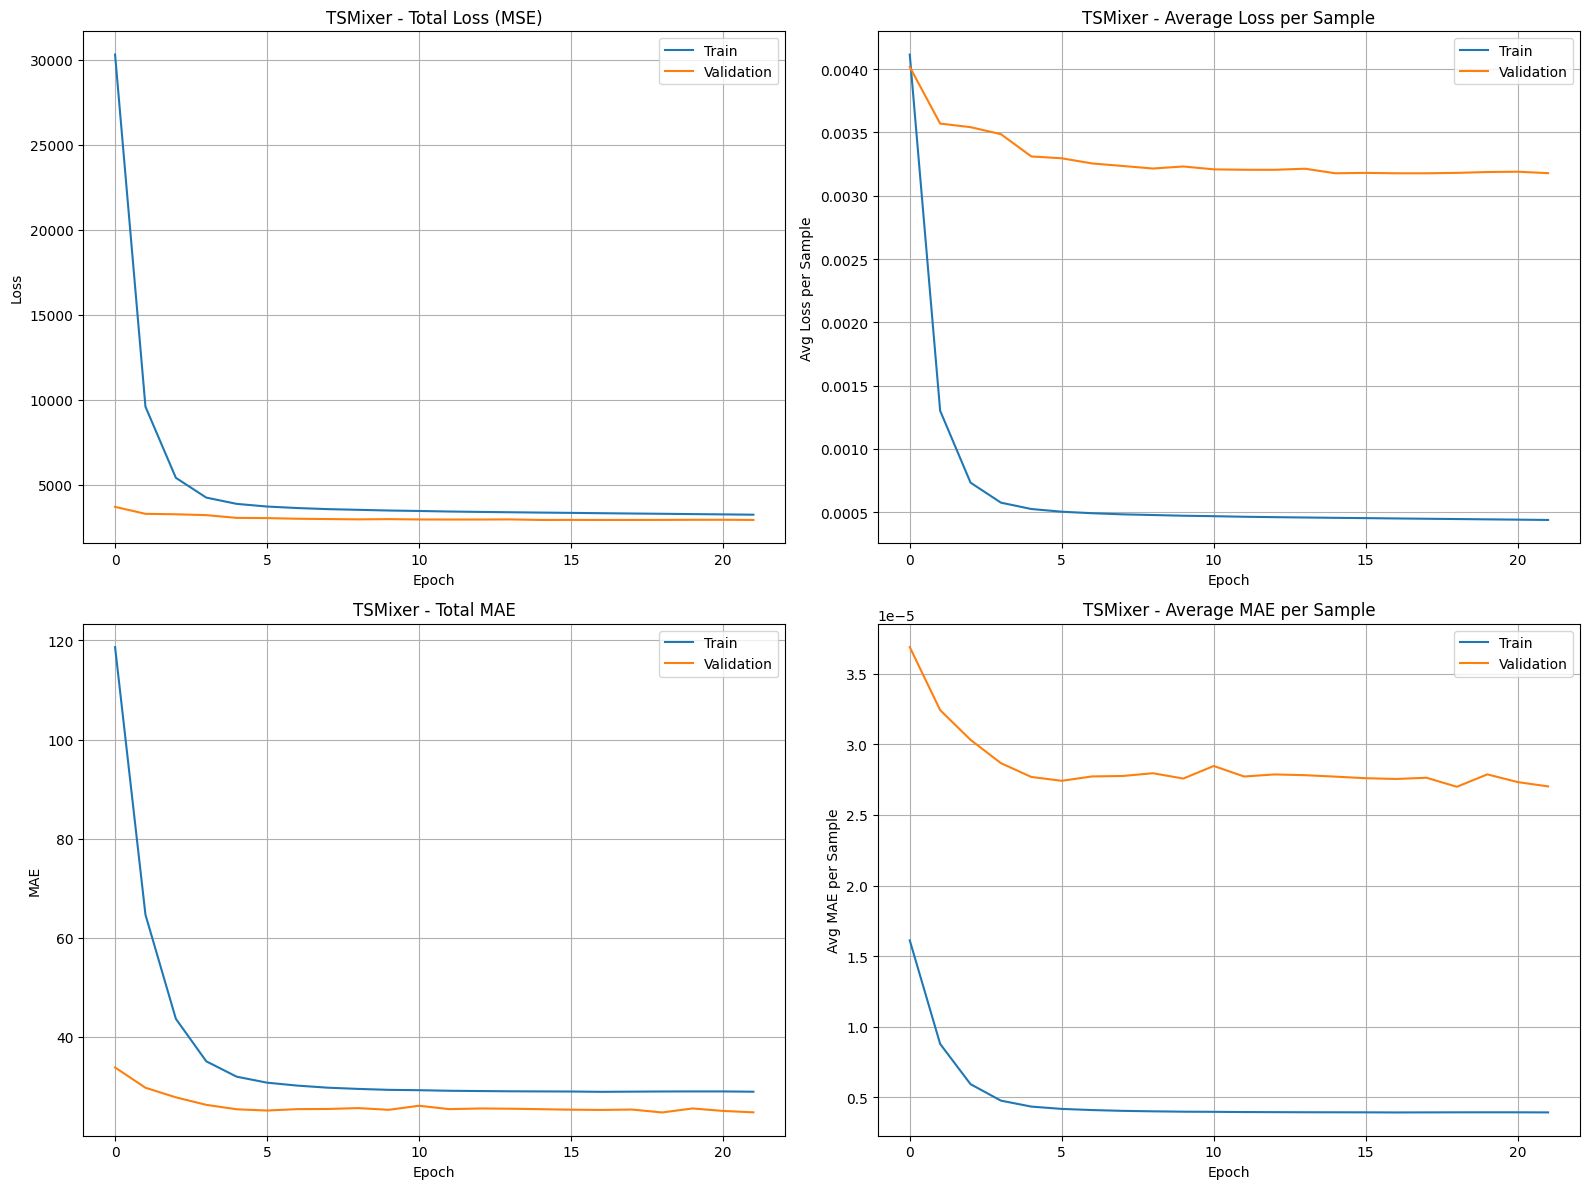


Evaluating TSMixer model on test set...



TSMixer - Test Evaluation Metrics:
  Overall:  MSE: 2789.60, RMSE: 52.82, MAE: 24.69, R²: 0.9699, MASE: 0.49
  Daytime:  MSE: 5593.08, RMSE: 74.79, MAE: 48.16, R²: 0.9321, MASE: 0.48
  Nighttime: MSE: 6.81, RMSE: 2.61, MAE: 1.39, R²: -1.6110, MASE: 13.70
  Inference Speed: 4982443.33 samples/sec, 0.2007 μs/sample
  Total time: 0.1846 sec for 919800 samples
Model saved to checkpoints/TSMixer_best_20250507_063935.pt with metadata.
Best model saved to checkpoints/TSMixer_best_20250507_063935.pt
Saved model checkpoint logged to wandb: checkpoints/TSMixer_best_20250507_063935.pt


test/inference_speed_samples_per_sec,▁
test/inference_time_us_per_sample,▁
test/mae,▁
test/mase,▁
test/mse,▁
test/r2,▁
test/rmse,▁
train/epoch,▁▁▂▂▂▃▃▃▄▄▄▅▅▅▆▆▆▇▇▇██
train/learning_rate,████████████████████▁▁
train/loss,█▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train/mae,█▄▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁


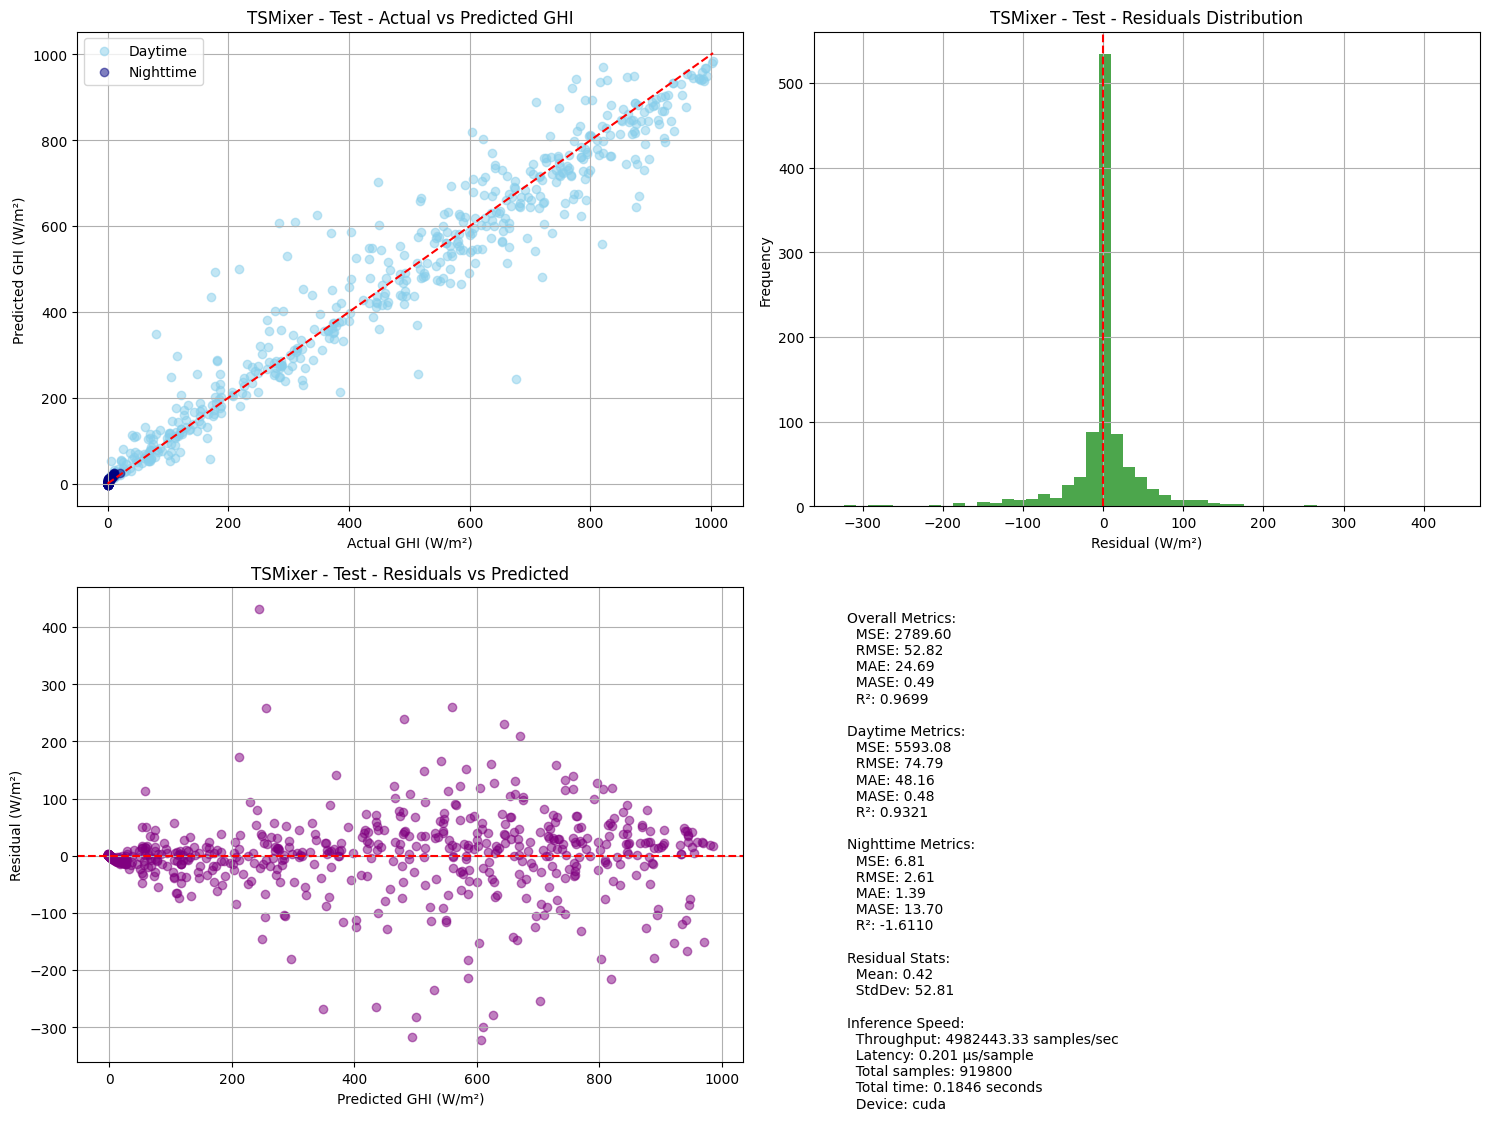

In [13]:
model_name = "TSMixer"

# Train the TSMixer model
tsmixer_history, tsmixer_val_metrics, tsmixer_test_metrics = run_experiment_pipeline(
    tsmixer_model,
    train_loader,
    val_loader,
    test_loader,
    model_name=model_name,
    epochs=N_EPOCHS,
    patience=PATIENCE,
    lr=LR
)

### 3.4 iTransformer Model

iTransformer is an innovative approach to time series forecasting that inverts the traditional Transformer architecture:

- **Inverted Attention Mechanism**: Applies self-attention across the feature dimension rather than the time dimension
- **Feature as Tokens**: Treats each feature as a token (rather than each timestamp)
- **Improved Feature Interactions**: Better captures correlations between different variables

For detailed model code: `models/itransformer.py`

In [14]:
from models.itransformer import iTransformerModel

# Create iTransformer model
itransformer_model = iTransformerModel(
    input_dim=temporal_dim,           # Number of input features
    static_dim=static_dim,            # Number of static features
    d_model=128,                      # Model dimension
    n_heads=4,                        # Number of attention heads
    e_layers=2,                       # Number of encoder layers
    d_ff=256,                         # Dimension of feedforward network
    dropout=0.1,                      # Dropout rate
    lookback=LOOKBACK,                # Historical sequence length
    pred_len=1                        # Prediction length
).to(device)

# Print the model
print_model_info(itransformer_model, temporal_features.shape, static_features.shape)

Error generating model summary: Failed to run torchinfo. See above stack traces for more details. Executed layers up to: []
Model: iTransformerModel
Total parameters: 271,106
Trainable parameters: 271,106
Non-trainable parameters: 0

Model structure:
iTransformerModel(
  (embedding): TokenEmbedding(
    (tokenConv): Linear(in_features=24, out_features=128, bias=True)
  )
  (pos_encoder): PositionalEncoding()
  (encoder): iTransformerEncoder(
    (encoder_layers): ModuleList(
      (0-1): 2 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=128, out_features=128, bias=True)
        )
        (linear1): Linear(in_features=128, out_features=256, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=256, out_features=128, bias=True)
        (norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((128,), eps=1e-05, elementwise_affin

Training iTransformer model...
track_experiment: USE_WANDB=True, wandb.run=None, keep_run_open=True
Error generating model summary: Failed to run torchinfo. See above stack traces for more details. Executed layers up to: []
Creating new wandb run for iTransformer


Training config: {'DEBUG_MODE': False, 'PATIENCE': 5, 'LR': 0.0001, 'N_EPOCHS': 30, 'BATCH_SIZE': 8192, 'NUM_WORKERS': 16, 'USE_WANDB': True, 'WANDB_USERNAME': 'tin-hoang', 'WANDB_PROJECT': 'EEEM073-Solar-Radiation', 'LOOKBACK': 24, 'TIME_FEATURES': ['hour_sin', 'hour_cos', 'day_sin', 'day_cos', 'month_sin', 'month_cos', 'dow_sin', 'dow_cos'], 'SELECTED_FEATURES': ['air_temperature', 'wind_speed', 'relative_humidity', 'cloud_type', 'solar_zenith_angle', 'clearsky_ghi', 'total_precipitable_water', 'surface_albedo', 'nighttime_mask', 'cld_opd_dcomp', 'aod'], 'STATIC_FEATURES': ['latitude', 'longitude', 'elevation'], 'TARGET_VARIABLE': 'ghi', 'TRAIN_PREPROCESSED_DATA_PATH': 'data/processed/train_normalized_20250430_145157.h5', 'VAL_PREPROCESSED_DATA_PATH': 'data/processed/val_normalized_20250430_145205.h5', 'TEST_PREPROCESSED_DATA_PATH': 'data/processed/test_normalized_20250430_145205.h5', 'SCALER_PATH': 'data/processed/scalers_20250430_145206.pkl', 'TEMPORAL_FEATURES_SHAPE': [8192, 24, 1


Validation iTransformer (Epoch 1) Evaluation Metrics:
  Overall:  MSE: 4743.02, RMSE: 68.87, MAE: 42.33, R²: 0.9482, MASE: 0.90
  Daytime:  MSE: 8991.40, RMSE: 94.82, MAE: 66.12, R²: 0.8874, MASE: 0.70
  Nighttime: MSE: 525.67, RMSE: 22.93, MAE: 18.72, R²: -195.6805, MASE: 181.77
  Inference Speed: 8028830.14 samples/sec, 0.1246 μs/sample
  Total time: 0.1142 sec for 917280 samples
Epoch 1/30 | Train Loss: 33970.0078, Train MAE: 132.3257 | Val Loss: 4743.0161, Val MAE: 42.3348 | LR: 0.000100



Validation iTransformer (Epoch 2) Evaluation Metrics:
  Overall:  MSE: 3931.35, RMSE: 62.70, MAE: 38.83, R²: 0.9571, MASE: 0.82
  Daytime:  MSE: 7474.46, RMSE: 86.45, MAE: 60.13, R²: 0.9064, MASE: 0.63
  Nighttime: MSE: 414.11, RMSE: 20.35, MAE: 17.69, R²: -153.9421, MASE: 171.80
  Inference Speed: 8921869.86 samples/sec, 0.1121 μs/sample
  Total time: 0.1028 sec for 917280 samples
Epoch 2/30 | Train Loss: 8410.4824, Train MAE: 65.5606 | Val Loss: 3931.3464, Val MAE: 38.8341 | LR: 0.000100



Validation iTransformer (Epoch 3) Evaluation Metrics:
  Overall:  MSE: 3670.93, RMSE: 60.59, MAE: 34.37, R²: 0.9599, MASE: 0.73
  Daytime:  MSE: 7079.68, RMSE: 84.14, MAE: 54.69, R²: 0.9114, MASE: 0.58
  Nighttime: MSE: 287.07, RMSE: 16.94, MAE: 14.21, R²: -106.4072, MASE: 137.98
  Inference Speed: 8033541.04 samples/sec, 0.1245 μs/sample
  Total time: 0.1142 sec for 917280 samples
Epoch 3/30 | Train Loss: 5773.0889, Train MAE: 50.0957 | Val Loss: 3670.9258, Val MAE: 34.3742 | LR: 0.000100



Validation iTransformer (Epoch 4) Evaluation Metrics:
  Overall:  MSE: 3541.77, RMSE: 59.51, MAE: 33.30, R²: 0.9614, MASE: 0.71
  Daytime:  MSE: 6918.96, RMSE: 83.18, MAE: 54.44, R²: 0.9134, MASE: 0.57
  Nighttime: MSE: 189.24, RMSE: 13.76, MAE: 12.32, R²: -69.8039, MASE: 119.61
  Inference Speed: 7947299.31 samples/sec, 0.1258 μs/sample
  Total time: 0.1154 sec for 917280 samples
Epoch 4/30 | Train Loss: 4885.9580, Train MAE: 43.3125 | Val Loss: 3541.7656, Val MAE: 33.3022 | LR: 0.000100



Validation iTransformer (Epoch 5) Evaluation Metrics:
  Overall:  MSE: 3425.50, RMSE: 58.53, MAE: 32.59, R²: 0.9626, MASE: 0.69
  Daytime:  MSE: 6734.31, RMSE: 82.06, MAE: 54.30, R²: 0.9157, MASE: 0.57
  Nighttime: MSE: 140.85, RMSE: 11.87, MAE: 11.04, R²: -51.7002, MASE: 107.17
  Inference Speed: 8296014.04 samples/sec, 0.1205 μs/sample
  Total time: 0.1106 sec for 917280 samples
Epoch 5/30 | Train Loss: 4440.0801, Train MAE: 39.2367 | Val Loss: 3425.4995, Val MAE: 32.5906 | LR: 0.000100



Validation iTransformer (Epoch 6) Evaluation Metrics:
  Overall:  MSE: 3431.07, RMSE: 58.58, MAE: 31.72, R²: 0.9626, MASE: 0.67
  Daytime:  MSE: 6822.90, RMSE: 82.60, MAE: 56.33, R²: 0.9146, MASE: 0.59
  Nighttime: MSE: 64.02, RMSE: 8.00, MAE: 7.29, R²: -22.9527, MASE: 70.79
  Inference Speed: 7727839.32 samples/sec, 0.1294 μs/sample
  Total time: 0.1187 sec for 917280 samples
Epoch 6/30 | Train Loss: 4147.1343, Train MAE: 36.3309 | Val Loss: 3431.0742, Val MAE: 31.7181 | LR: 0.000100



Validation iTransformer (Epoch 7) Evaluation Metrics:
  Overall:  MSE: 3248.81, RMSE: 57.00, MAE: 28.44, R²: 0.9645, MASE: 0.60
  Daytime:  MSE: 6505.93, RMSE: 80.66, MAE: 53.38, R²: 0.9185, MASE: 0.56
  Nighttime: MSE: 15.49, RMSE: 3.94, MAE: 3.67, R²: -4.7943, MASE: 35.68
  Inference Speed: 7955006.05 samples/sec, 0.1257 μs/sample
  Total time: 0.1153 sec for 917280 samples
Epoch 7/30 | Train Loss: 3964.7905, Train MAE: 34.3031 | Val Loss: 3248.8127, Val MAE: 28.4380 | LR: 0.000100



Validation iTransformer (Epoch 8) Evaluation Metrics:
  Overall:  MSE: 3263.23, RMSE: 57.12, MAE: 28.52, R²: 0.9644, MASE: 0.60
  Daytime:  MSE: 6539.89, RMSE: 80.87, MAE: 54.16, R²: 0.9181, MASE: 0.57
  Nighttime: MSE: 10.51, RMSE: 3.24, MAE: 3.07, R²: -2.9322, MASE: 29.85
  Inference Speed: 8189652.16 samples/sec, 0.1221 μs/sample
  Total time: 0.1120 sec for 917280 samples
Epoch 8/30 | Train Loss: 3840.7458, Train MAE: 33.0195 | Val Loss: 3263.2332, Val MAE: 28.5217 | LR: 0.000100



Validation iTransformer (Epoch 9) Evaluation Metrics:
  Overall:  MSE: 3295.37, RMSE: 57.41, MAE: 29.63, R²: 0.9640, MASE: 0.63
  Daytime:  MSE: 6606.01, RMSE: 81.28, MAE: 56.59, R²: 0.9173, MASE: 0.60
  Nighttime: MSE: 8.90, RMSE: 2.98, MAE: 2.87, R²: -2.3317, MASE: 27.88
  Inference Speed: 8503598.67 samples/sec, 0.1176 μs/sample
  Total time: 0.1079 sec for 917280 samples
Epoch 9/30 | Train Loss: 3756.5054, Train MAE: 32.3196 | Val Loss: 3295.3665, Val MAE: 29.6344 | LR: 0.000100



Validation iTransformer (Epoch 10) Evaluation Metrics:
  Overall:  MSE: 3189.68, RMSE: 56.48, MAE: 27.03, R²: 0.9652, MASE: 0.57
  Daytime:  MSE: 6398.02, RMSE: 79.99, MAE: 52.20, R²: 0.9199, MASE: 0.55
  Nighttime: MSE: 4.77, RMSE: 2.18, MAE: 2.04, R²: -0.7846, MASE: 19.86
  Inference Speed: 9057172.86 samples/sec, 0.1104 μs/sample
  Total time: 0.1013 sec for 917280 samples
Epoch 10/30 | Train Loss: 3703.5034, Train MAE: 32.0222 | Val Loss: 3189.6809, Val MAE: 27.0294 | LR: 0.000100



Validation iTransformer (Epoch 11) Evaluation Metrics:
  Overall:  MSE: 3326.84, RMSE: 57.68, MAE: 29.60, R²: 0.9637, MASE: 0.63
  Daytime:  MSE: 6666.72, RMSE: 81.65, MAE: 56.14, R²: 0.9165, MASE: 0.59
  Nighttime: MSE: 11.36, RMSE: 3.37, MAE: 3.25, R²: -3.2494, MASE: 31.55
  Inference Speed: 8398441.34 samples/sec, 0.1191 μs/sample
  Total time: 0.1092 sec for 917280 samples
Epoch 11/30 | Train Loss: 3663.9116, Train MAE: 31.9351 | Val Loss: 3326.8406, Val MAE: 29.5957 | LR: 0.000100



Validation iTransformer (Epoch 12) Evaluation Metrics:
  Overall:  MSE: 3147.85, RMSE: 56.11, MAE: 27.35, R²: 0.9656, MASE: 0.58
  Daytime:  MSE: 6313.47, RMSE: 79.46, MAE: 52.68, R²: 0.9210, MASE: 0.56
  Nighttime: MSE: 5.34, RMSE: 2.31, MAE: 2.20, R²: -0.9996, MASE: 21.37
  Inference Speed: 8609900.31 samples/sec, 0.1161 μs/sample
  Total time: 0.1065 sec for 917280 samples
Epoch 12/30 | Train Loss: 3629.9470, Train MAE: 31.8906 | Val Loss: 3147.8462, Val MAE: 27.3464 | LR: 0.000100



Validation iTransformer (Epoch 13) Evaluation Metrics:
  Overall:  MSE: 3184.24, RMSE: 56.43, MAE: 28.32, R²: 0.9653, MASE: 0.60
  Daytime:  MSE: 6384.03, RMSE: 79.90, MAE: 54.13, R²: 0.9201, MASE: 0.57
  Nighttime: MSE: 7.83, RMSE: 2.80, MAE: 2.69, R²: -1.9293, MASE: 26.16
  Inference Speed: 8068533.65 samples/sec, 0.1239 μs/sample
  Total time: 0.1137 sec for 917280 samples
Epoch 13/30 | Train Loss: 3599.2393, Train MAE: 31.8442 | Val Loss: 3184.2441, Val MAE: 28.3155 | LR: 0.000100



Validation iTransformer (Epoch 14) Evaluation Metrics:
  Overall:  MSE: 3227.60, RMSE: 56.81, MAE: 28.27, R²: 0.9648, MASE: 0.60
  Daytime:  MSE: 6474.35, RMSE: 80.46, MAE: 54.74, R²: 0.9189, MASE: 0.58
  Nighttime: MSE: 4.56, RMSE: 2.13, MAE: 1.99, R²: -0.7048, MASE: 19.34
  Inference Speed: 7929985.00 samples/sec, 0.1261 μs/sample
  Total time: 0.1157 sec for 917280 samples
Epoch 14/30 | Train Loss: 3568.7412, Train MAE: 31.8177 | Val Loss: 3227.5981, Val MAE: 28.2677 | LR: 0.000100



Validation iTransformer (Epoch 15) Evaluation Metrics:
  Overall:  MSE: 3134.83, RMSE: 55.99, MAE: 26.85, R²: 0.9658, MASE: 0.57
  Daytime:  MSE: 6287.91, RMSE: 79.30, MAE: 51.84, R²: 0.9213, MASE: 0.55
  Nighttime: MSE: 4.78, RMSE: 2.19, MAE: 2.05, R²: -0.7901, MASE: 19.88
  Inference Speed: 9898582.04 samples/sec, 0.1010 μs/sample
  Total time: 0.0927 sec for 917280 samples
Epoch 15/30 | Train Loss: 3540.6562, Train MAE: 31.7701 | Val Loss: 3134.8320, Val MAE: 26.8512 | LR: 0.000100



Validation iTransformer (Epoch 16) Evaluation Metrics:
  Overall:  MSE: 3137.42, RMSE: 56.01, MAE: 26.96, R²: 0.9658, MASE: 0.57
  Daytime:  MSE: 6294.47, RMSE: 79.34, MAE: 52.46, R²: 0.9212, MASE: 0.55
  Nighttime: MSE: 3.44, RMSE: 1.85, MAE: 1.65, R²: -0.2866, MASE: 16.05
  Inference Speed: 8245024.77 samples/sec, 0.1213 μs/sample
  Total time: 0.1113 sec for 917280 samples
Epoch 16/30 | Train Loss: 3525.2581, Train MAE: 31.7323 | Val Loss: 3137.4241, Val MAE: 26.9634 | LR: 0.000100



Validation iTransformer (Epoch 17) Evaluation Metrics:
  Overall:  MSE: 3088.07, RMSE: 55.57, MAE: 25.89, R²: 0.9663, MASE: 0.55
  Daytime:  MSE: 6196.99, RMSE: 78.72, MAE: 50.84, R²: 0.9224, MASE: 0.54
  Nighttime: MSE: 1.85, RMSE: 1.36, MAE: 1.12, R²: 0.3064, MASE: 10.92
  Inference Speed: 7910338.16 samples/sec, 0.1264 μs/sample
  Total time: 0.1160 sec for 917280 samples
Epoch 17/30 | Train Loss: 3497.4185, Train MAE: 31.5881 | Val Loss: 3088.0686, Val MAE: 25.8893 | LR: 0.000100



Validation iTransformer (Epoch 18) Evaluation Metrics:
  Overall:  MSE: 3132.58, RMSE: 55.97, MAE: 26.43, R²: 0.9658, MASE: 0.56
  Daytime:  MSE: 6286.17, RMSE: 79.29, MAE: 51.87, R²: 0.9213, MASE: 0.55
  Nighttime: MSE: 2.04, RMSE: 1.43, MAE: 1.17, R²: 0.2386, MASE: 11.38
  Inference Speed: 7664107.23 samples/sec, 0.1305 μs/sample
  Total time: 0.1197 sec for 917280 samples
Epoch 18/30 | Train Loss: 3480.0974, Train MAE: 31.5669 | Val Loss: 3132.5835, Val MAE: 26.4266 | LR: 0.000100



Validation iTransformer (Epoch 19) Evaluation Metrics:
  Overall:  MSE: 3120.33, RMSE: 55.86, MAE: 27.52, R²: 0.9659, MASE: 0.58
  Daytime:  MSE: 6259.36, RMSE: 79.12, MAE: 53.35, R²: 0.9216, MASE: 0.56
  Nighttime: MSE: 4.23, RMSE: 2.06, MAE: 1.87, R²: -0.5815, MASE: 18.18
  Inference Speed: 8618347.93 samples/sec, 0.1160 μs/sample
  Total time: 0.1064 sec for 917280 samples
Epoch 19/30 | Train Loss: 3463.4329, Train MAE: 31.5491 | Val Loss: 3120.3311, Val MAE: 27.5172 | LR: 0.000100



Validation iTransformer (Epoch 20) Evaluation Metrics:
  Overall:  MSE: 3093.17, RMSE: 55.62, MAE: 26.89, R²: 0.9662, MASE: 0.57
  Daytime:  MSE: 6206.65, RMSE: 78.78, MAE: 52.63, R²: 0.9223, MASE: 0.56
  Nighttime: MSE: 2.42, RMSE: 1.56, MAE: 1.35, R²: 0.0945, MASE: 13.08
  Inference Speed: 7976380.24 samples/sec, 0.1254 μs/sample
  Total time: 0.1150 sec for 917280 samples
Epoch 20/30 | Train Loss: 3446.1321, Train MAE: 31.5082 | Val Loss: 3093.1658, Val MAE: 26.8939 | LR: 0.000100



Validation iTransformer (Epoch 21) Evaluation Metrics:
  Overall:  MSE: 3194.17, RMSE: 56.52, MAE: 27.66, R²: 0.9651, MASE: 0.59
  Daytime:  MSE: 6410.07, RMSE: 80.06, MAE: 54.56, R²: 0.9197, MASE: 0.58
  Nighttime: MSE: 1.76, RMSE: 1.33, MAE: 0.97, R²: 0.3410, MASE: 9.38
  Inference Speed: 8230649.31 samples/sec, 0.1215 μs/sample
  Total time: 0.1114 sec for 917280 samples
Epoch 21/30 | Train Loss: 3431.1724, Train MAE: 31.4362 | Val Loss: 3194.1736, Val MAE: 27.6624 | LR: 0.000100



Validation iTransformer (Epoch 22) Evaluation Metrics:
  Overall:  MSE: 3043.44, RMSE: 55.17, MAE: 25.39, R²: 0.9668, MASE: 0.54
  Daytime:  MSE: 6108.38, RMSE: 78.16, MAE: 50.37, R²: 0.9235, MASE: 0.53
  Nighttime: MSE: 0.88, RMSE: 0.94, MAE: 0.58, R²: 0.6709, MASE: 5.65
  Inference Speed: 8066199.22 samples/sec, 0.1240 μs/sample
  Total time: 0.1137 sec for 917280 samples
Epoch 22/30 | Train Loss: 3420.9106, Train MAE: 31.3921 | Val Loss: 3043.4370, Val MAE: 25.3853 | LR: 0.000100



Validation iTransformer (Epoch 23) Evaluation Metrics:
  Overall:  MSE: 3088.39, RMSE: 55.57, MAE: 26.11, R²: 0.9663, MASE: 0.55
  Daytime:  MSE: 6196.76, RMSE: 78.72, MAE: 50.90, R²: 0.9224, MASE: 0.54
  Nighttime: MSE: 2.72, RMSE: 1.65, MAE: 1.50, R²: -0.0168, MASE: 14.53
  Inference Speed: 7676692.82 samples/sec, 0.1303 μs/sample
  Total time: 0.1195 sec for 917280 samples
Epoch 23/30 | Train Loss: 3411.5476, Train MAE: 31.3967 | Val Loss: 3088.3877, Val MAE: 26.1090 | LR: 0.000100



Validation iTransformer (Epoch 24) Evaluation Metrics:
  Overall:  MSE: 3106.46, RMSE: 55.74, MAE: 25.27, R²: 0.9661, MASE: 0.54
  Daytime:  MSE: 6232.14, RMSE: 78.94, MAE: 48.96, R²: 0.9220, MASE: 0.52
  Nighttime: MSE: 3.60, RMSE: 1.90, MAE: 1.77, R²: -0.3472, MASE: 17.15
  Inference Speed: 8555506.03 samples/sec, 0.1169 μs/sample
  Total time: 0.1072 sec for 917280 samples
Epoch 24/30 | Train Loss: 3396.7163, Train MAE: 31.3754 | Val Loss: 3106.4580, Val MAE: 25.2743 | LR: 0.000100



Validation iTransformer (Epoch 25) Evaluation Metrics:
  Overall:  MSE: 3070.93, RMSE: 55.42, MAE: 25.86, R²: 0.9665, MASE: 0.55
  Daytime:  MSE: 6162.27, RMSE: 78.50, MAE: 50.67, R²: 0.9228, MASE: 0.53
  Nighttime: MSE: 2.17, RMSE: 1.47, MAE: 1.23, R²: 0.1884, MASE: 11.90
  Inference Speed: 8125397.15 samples/sec, 0.1231 μs/sample
  Total time: 0.1129 sec for 917280 samples
Epoch 25/30 | Train Loss: 3388.0625, Train MAE: 31.3673 | Val Loss: 3070.9341, Val MAE: 25.8564 | LR: 0.000100



Validation iTransformer (Epoch 26) Evaluation Metrics:
  Overall:  MSE: 3084.47, RMSE: 55.54, MAE: 27.14, R²: 0.9663, MASE: 0.57
  Daytime:  MSE: 6188.81, RMSE: 78.67, MAE: 52.93, R²: 0.9225, MASE: 0.56
  Nighttime: MSE: 2.81, RMSE: 1.68, MAE: 1.53, R²: -0.0526, MASE: 14.90
  Inference Speed: 7613044.83 samples/sec, 0.1314 μs/sample
  Total time: 0.1205 sec for 917280 samples
Epoch 26/30 | Train Loss: 3381.0571, Train MAE: 31.3561 | Val Loss: 3084.4729, Val MAE: 27.1381 | LR: 0.000100



Validation iTransformer (Epoch 27) Evaluation Metrics:
  Overall:  MSE: 3128.01, RMSE: 55.93, MAE: 27.23, R²: 0.9659, MASE: 0.58
  Daytime:  MSE: 6277.99, RMSE: 79.23, MAE: 53.88, R²: 0.9214, MASE: 0.57
  Nighttime: MSE: 1.03, RMSE: 1.01, MAE: 0.78, R²: 0.6150, MASE: 7.54
  Inference Speed: 9193873.80 samples/sec, 0.1088 μs/sample
  Total time: 0.0998 sec for 917280 samples
Epoch 27/30 | Train Loss: 3364.4763, Train MAE: 31.2819 | Val Loss: 3128.0078, Val MAE: 27.2328 | LR: 0.000100
Early stopping at epoch 27
Loading best model from training session. The model object now can be used to make predictions.
Keeping wandb run open as requested (keep_run_open=True)


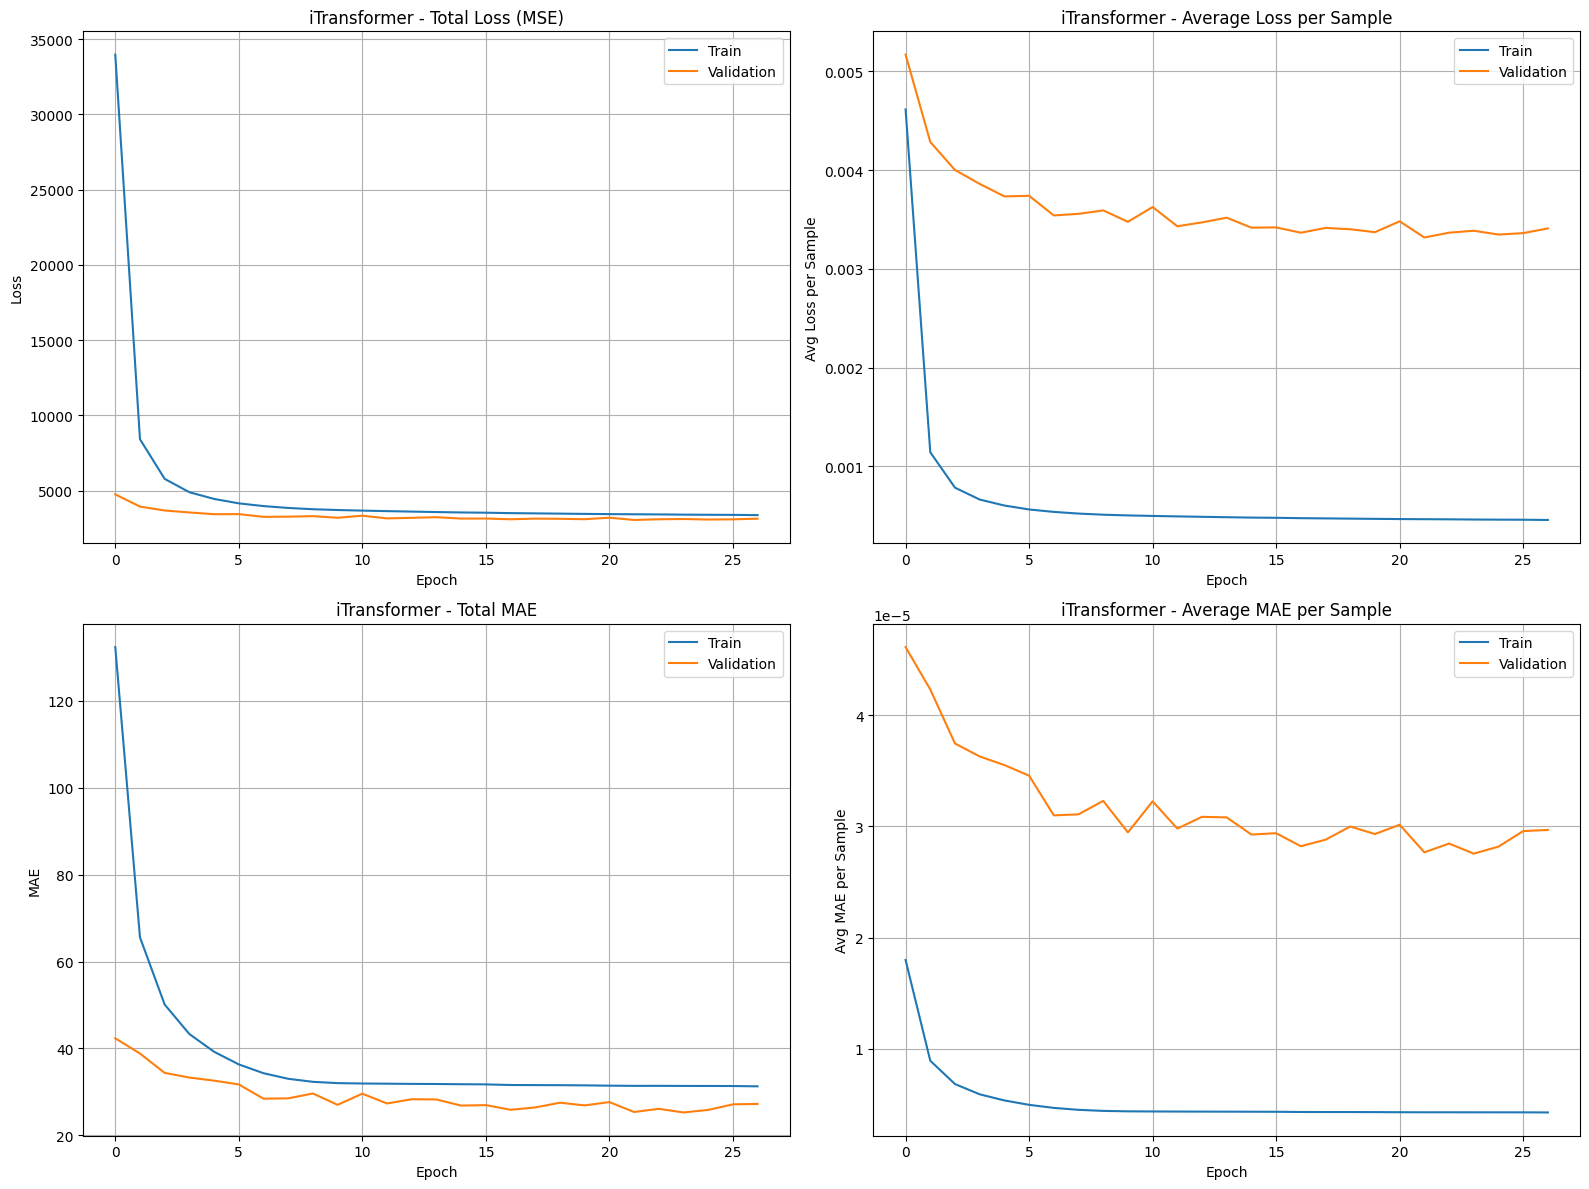


Evaluating iTransformer model on test set...



iTransformer - Test Evaluation Metrics:
  Overall:  MSE: 2954.25, RMSE: 54.35, MAE: 26.71, R²: 0.9681, MASE: 0.53
  Daytime:  MSE: 5929.46, RMSE: 77.00, MAE: 52.85, R²: 0.9280, MASE: 0.52
  Nighttime: MSE: 1.00, RMSE: 1.00, MAE: 0.77, R²: 0.6179, MASE: 7.54
  Inference Speed: 8228370.37 samples/sec, 0.1215 μs/sample
  Total time: 0.1118 sec for 919800 samples
Model saved to checkpoints/iTransformer_best_20250507_075108.pt with metadata.
Best model saved to checkpoints/iTransformer_best_20250507_075108.pt
Saved model checkpoint logged to wandb: checkpoints/iTransformer_best_20250507_075108.pt


test/inference_speed_samples_per_sec,▁
test/inference_time_us_per_sample,▁
test/mae,▁
test/mase,▁
test/mse,▁
test/r2,▁
test/rmse,▁
train/epoch,▁▁▂▂▂▂▃▃▃▃▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇██
train/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train/loss,█▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train/mae,█▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁


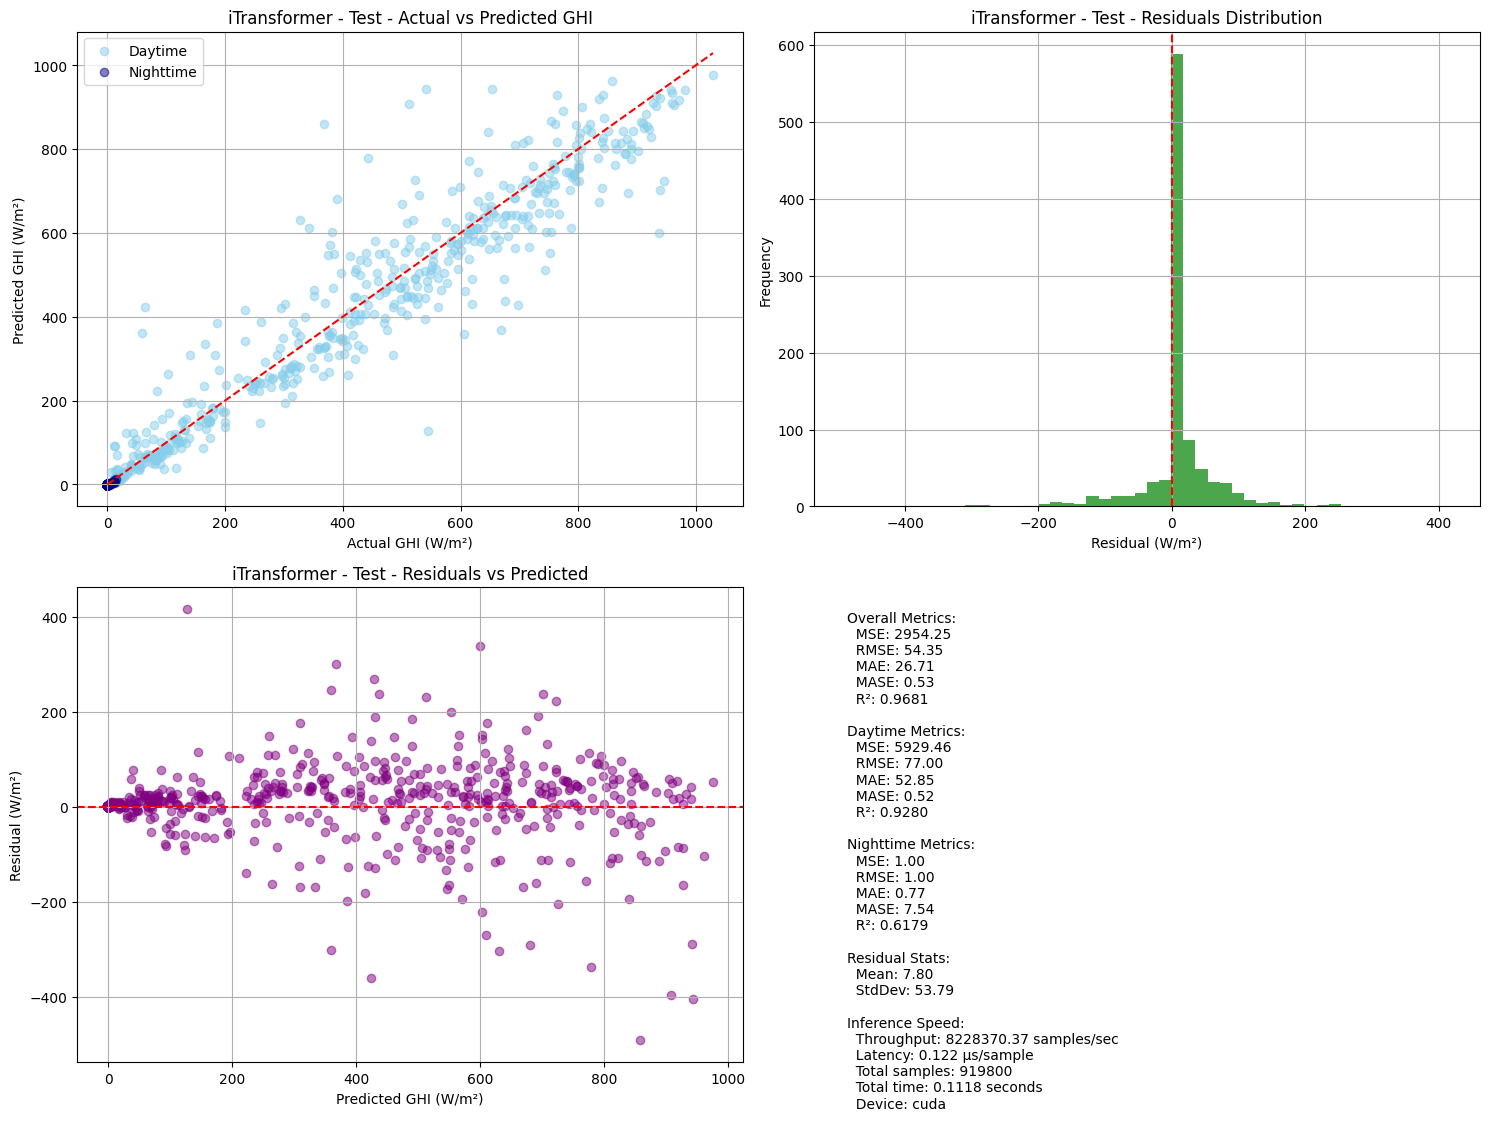

In [15]:
model_name = "iTransformer"

# Train the iTransformer model
itransformer_history, itransformer_val_metrics, itransformer_test_metrics = run_experiment_pipeline(
    itransformer_model,
    train_loader,
    val_loader,
    test_loader,
    model_name=model_name,
    epochs=N_EPOCHS,
    patience=PATIENCE,
    lr=LR
)

### 3.5 Mamba Model

Mamba is a state-of-the-art architecture that uses State Space Models (SSMs) instead of attention mechanisms:

- **Selective State Space Modeling**: Captures long-range dependencies with linear scaling to sequence length
- **Data-dependent Parameters**: Adapts model parameters based on input data
- **Local Convolution**: Enhances local pattern recognition with a convolutional layer
- **Efficient Processing**: Linear time complexity O(L) compared to quadratic complexity O(L²) of Transformers

For detailed model code: `models/mamba.py`

In [16]:
from models.mamba import MambaModel

# Create Mamba model
mamba_model = MambaModel(
    input_dim=temporal_dim,           # Number of input features
    static_dim=static_dim,            # Number of static features
    d_model=128,                      # Model dimension
    d_state=16,                       # State dimension for SSM
    n_layers=2,                       # Number of Mamba blocks
    dt_rank=32,                       # Rank for delta (Δ) projection
    d_conv=4,                         # Kernel size for local convolution
    expand_factor=2,                  # Expansion factor for inner dimension
    dt_min=0.001,                     # Minimum delta value
    dt_max=0.1,                       # Maximum delta value
    dropout=0.1,                      # Dropout rate
).to(device)

# Print the model
print_model_info(mamba_model, temporal_features.shape, static_features.shape)

Error generating model summary: Failed to run torchinfo. See above stack traces for more details. Executed layers up to: []
Model: MambaModel
Total parameters: 250,049
Trainable parameters: 250,049
Non-trainable parameters: 0

Model structure:
MambaModel(
  (temporal_proj): Linear(in_features=19, out_features=128, bias=True)
  (static_proj): Sequential(
    (0): Linear(in_features=3, out_features=64, bias=True)
    (1): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
    (2): SiLU()
    (3): Dropout(p=0.1, inplace=False)
  )
  (mamba_blocks): ModuleList(
    (0-1): 2 x MambaBlock(
      (in_proj): Linear(in_features=128, out_features=512, bias=False)
      (conv1d): Conv1d(256, 256, kernel_size=(4,), stride=(1,), padding=(3,), groups=256)
      (norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
      (norm_inner): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
      (ssm): SelectiveSSM(
        (dt_proj): Linear(in_features=256, out_features=32, bias=True)
      

Training Mamba model...
track_experiment: USE_WANDB=True, wandb.run=None, keep_run_open=True
Error generating model summary: Failed to run torchinfo. See above stack traces for more details. Executed layers up to: []
Creating new wandb run for Mamba


Training config: {'DEBUG_MODE': False, 'PATIENCE': 5, 'LR': 0.0001, 'N_EPOCHS': 30, 'BATCH_SIZE': 8192, 'NUM_WORKERS': 16, 'USE_WANDB': True, 'WANDB_USERNAME': 'tin-hoang', 'WANDB_PROJECT': 'EEEM073-Solar-Radiation', 'LOOKBACK': 24, 'TIME_FEATURES': ['hour_sin', 'hour_cos', 'day_sin', 'day_cos', 'month_sin', 'month_cos', 'dow_sin', 'dow_cos'], 'SELECTED_FEATURES': ['air_temperature', 'wind_speed', 'relative_humidity', 'cloud_type', 'solar_zenith_angle', 'clearsky_ghi', 'total_precipitable_water', 'surface_albedo', 'nighttime_mask', 'cld_opd_dcomp', 'aod'], 'STATIC_FEATURES': ['latitude', 'longitude', 'elevation'], 'TARGET_VARIABLE': 'ghi', 'TRAIN_PREPROCESSED_DATA_PATH': 'data/processed/train_normalized_20250430_145157.h5', 'VAL_PREPROCESSED_DATA_PATH': 'data/processed/val_normalized_20250430_145205.h5', 'TEST_PREPROCESSED_DATA_PATH': 'data/processed/test_normalized_20250430_145205.h5', 'SCALER_PATH': 'data/processed/scalers_20250430_145206.pkl', 'TEMPORAL_FEATURES_SHAPE': [8192, 24, 1


Validation Mamba (Epoch 1) Evaluation Metrics:
  Overall:  MSE: 3390.16, RMSE: 58.23, MAE: 29.86, R²: 0.9630, MASE: 0.63
  Daytime:  MSE: 6773.48, RMSE: 82.30, MAE: 55.59, R²: 0.9152, MASE: 0.59
  Nighttime: MSE: 31.54, RMSE: 5.62, MAE: 4.32, R²: -10.8011, MASE: 41.95
  Inference Speed: 2093466.16 samples/sec, 0.4777 μs/sample
  Total time: 0.4382 sec for 917280 samples
Epoch 1/30 | Train Loss: 11015.1025, Train MAE: 62.7309 | Val Loss: 3390.1570, Val MAE: 29.8590 | LR: 0.000100



Validation Mamba (Epoch 2) Evaluation Metrics:
  Overall:  MSE: 3222.44, RMSE: 56.77, MAE: 27.39, R²: 0.9648, MASE: 0.58
  Daytime:  MSE: 6438.37, RMSE: 80.24, MAE: 50.76, R²: 0.9194, MASE: 0.54
  Nighttime: MSE: 29.99, RMSE: 5.48, MAE: 4.20, R²: -10.2221, MASE: 40.76
  Inference Speed: 2085306.66 samples/sec, 0.4795 μs/sample
  Total time: 0.4399 sec for 917280 samples
Epoch 2/30 | Train Loss: 4081.7190, Train MAE: 35.8852 | Val Loss: 3222.4390, Val MAE: 27.3940 | LR: 0.000100



Validation Mamba (Epoch 3) Evaluation Metrics:
  Overall:  MSE: 3079.44, RMSE: 55.49, MAE: 27.17, R²: 0.9664, MASE: 0.58
  Daytime:  MSE: 6170.50, RMSE: 78.55, MAE: 52.17, R²: 0.9227, MASE: 0.55
  Nighttime: MSE: 10.96, RMSE: 3.31, MAE: 2.35, R²: -3.1015, MASE: 22.81
  Inference Speed: 2380654.03 samples/sec, 0.4201 μs/sample
  Total time: 0.3853 sec for 917280 samples
Epoch 3/30 | Train Loss: 3772.1125, Train MAE: 33.2010 | Val Loss: 3079.4419, Val MAE: 27.1671 | LR: 0.000100



Validation Mamba (Epoch 4) Evaluation Metrics:
  Overall:  MSE: 3168.13, RMSE: 56.29, MAE: 28.77, R²: 0.9654, MASE: 0.61
  Daytime:  MSE: 6349.28, RMSE: 79.68, MAE: 55.28, R²: 0.9205, MASE: 0.58
  Nighttime: MSE: 10.22, RMSE: 3.20, MAE: 2.45, R²: -2.8238, MASE: 23.78
  Inference Speed: 2173007.56 samples/sec, 0.4602 μs/sample
  Total time: 0.4221 sec for 917280 samples
Epoch 4/30 | Train Loss: 3628.2737, Train MAE: 31.8553 | Val Loss: 3168.1348, Val MAE: 28.7676 | LR: 0.000100



Validation Mamba (Epoch 5) Evaluation Metrics:
  Overall:  MSE: 3035.54, RMSE: 55.10, MAE: 25.99, R²: 0.9669, MASE: 0.55
  Daytime:  MSE: 6085.56, RMSE: 78.01, MAE: 49.97, R²: 0.9238, MASE: 0.53
  Nighttime: MSE: 7.79, RMSE: 2.79, MAE: 2.19, R²: -1.9161, MASE: 21.25
  Inference Speed: 2258094.93 samples/sec, 0.4429 μs/sample
  Total time: 0.4062 sec for 917280 samples
Epoch 5/30 | Train Loss: 3538.4517, Train MAE: 30.9771 | Val Loss: 3035.5376, Val MAE: 25.9924 | LR: 0.000100



Validation Mamba (Epoch 6) Evaluation Metrics:
  Overall:  MSE: 3023.47, RMSE: 54.99, MAE: 25.45, R²: 0.9670, MASE: 0.54
  Daytime:  MSE: 6063.59, RMSE: 77.87, MAE: 49.42, R²: 0.9241, MASE: 0.52
  Nighttime: MSE: 5.56, RMSE: 2.36, MAE: 1.65, R²: -1.0810, MASE: 16.05
  Inference Speed: 1820740.91 samples/sec, 0.5492 μs/sample
  Total time: 0.5038 sec for 917280 samples
Epoch 6/30 | Train Loss: 3468.3828, Train MAE: 30.2557 | Val Loss: 3023.4724, Val MAE: 25.4471 | LR: 0.000100



Validation Mamba (Epoch 7) Evaluation Metrics:
  Overall:  MSE: 3054.76, RMSE: 55.27, MAE: 25.84, R²: 0.9667, MASE: 0.55
  Daytime:  MSE: 6122.89, RMSE: 78.25, MAE: 49.26, R²: 0.9233, MASE: 0.52
  Nighttime: MSE: 9.05, RMSE: 3.01, MAE: 2.60, R²: -2.3863, MASE: 25.24
  Inference Speed: 1757261.19 samples/sec, 0.5691 μs/sample
  Total time: 0.5220 sec for 917280 samples
Epoch 7/30 | Train Loss: 3406.9014, Train MAE: 29.6358 | Val Loss: 3054.7644, Val MAE: 25.8424 | LR: 0.000100



Validation Mamba (Epoch 8) Evaluation Metrics:
  Overall:  MSE: 3012.38, RMSE: 54.89, MAE: 25.81, R²: 0.9671, MASE: 0.55
  Daytime:  MSE: 6038.72, RMSE: 77.71, MAE: 49.33, R²: 0.9244, MASE: 0.52
  Nighttime: MSE: 8.14, RMSE: 2.85, MAE: 2.45, R²: -2.0458, MASE: 23.80
  Inference Speed: 1607783.17 samples/sec, 0.6220 μs/sample
  Total time: 0.5705 sec for 917280 samples
Epoch 8/30 | Train Loss: 3349.9729, Train MAE: 29.0580 | Val Loss: 3012.3804, Val MAE: 25.8064 | LR: 0.000100



Validation Mamba (Epoch 9) Evaluation Metrics:
  Overall:  MSE: 3018.53, RMSE: 54.94, MAE: 25.62, R²: 0.9671, MASE: 0.54
  Daytime:  MSE: 6053.75, RMSE: 77.81, MAE: 49.48, R²: 0.9242, MASE: 0.52
  Nighttime: MSE: 5.48, RMSE: 2.34, MAE: 1.93, R²: -1.0517, MASE: 18.77
  Inference Speed: 1971003.32 samples/sec, 0.5074 μs/sample
  Total time: 0.4654 sec for 917280 samples
Epoch 9/30 | Train Loss: 3299.9822, Train MAE: 28.6304 | Val Loss: 3018.5308, Val MAE: 25.6191 | LR: 0.000100



Validation Mamba (Epoch 10) Evaluation Metrics:
  Overall:  MSE: 3084.18, RMSE: 55.54, MAE: 25.13, R²: 0.9663, MASE: 0.53
  Daytime:  MSE: 6187.71, RMSE: 78.66, MAE: 49.20, R²: 0.9225, MASE: 0.52
  Nighttime: MSE: 3.31, RMSE: 1.82, MAE: 1.25, R²: -0.2400, MASE: 12.13
  Inference Speed: 1919359.91 samples/sec, 0.5210 μs/sample
  Total time: 0.4779 sec for 917280 samples
Epoch 10/30 | Train Loss: 3258.1611, Train MAE: 28.3049 | Val Loss: 3084.1777, Val MAE: 25.1346 | LR: 0.000100



Validation Mamba (Epoch 11) Evaluation Metrics:
  Overall:  MSE: 3061.48, RMSE: 55.33, MAE: 26.21, R²: 0.9666, MASE: 0.55
  Daytime:  MSE: 6140.77, RMSE: 78.36, MAE: 50.93, R²: 0.9231, MASE: 0.54
  Nighttime: MSE: 4.68, RMSE: 2.16, MAE: 1.67, R²: -0.7507, MASE: 16.22
  Inference Speed: 1985944.89 samples/sec, 0.5035 μs/sample
  Total time: 0.4619 sec for 917280 samples
Epoch 11/30 | Train Loss: 3217.7883, Train MAE: 28.0718 | Val Loss: 3061.4783, Val MAE: 26.2081 | LR: 0.000100



Validation Mamba (Epoch 12) Evaluation Metrics:
  Overall:  MSE: 3059.82, RMSE: 55.32, MAE: 26.08, R²: 0.9666, MASE: 0.55
  Daytime:  MSE: 6138.35, RMSE: 78.35, MAE: 50.71, R²: 0.9231, MASE: 0.54
  Nighttime: MSE: 3.77, RMSE: 1.94, MAE: 1.62, R²: -0.4119, MASE: 15.75
  Inference Speed: 2263189.02 samples/sec, 0.4419 μs/sample
  Total time: 0.4053 sec for 917280 samples
Epoch 12/30 | Train Loss: 3175.8440, Train MAE: 27.8334 | Val Loss: 3059.8181, Val MAE: 26.0785 | LR: 0.000100



Validation Mamba (Epoch 13) Evaluation Metrics:
  Overall:  MSE: 3107.14, RMSE: 55.74, MAE: 24.92, R²: 0.9661, MASE: 0.53
  Daytime:  MSE: 6234.77, RMSE: 78.96, MAE: 49.04, R²: 0.9219, MASE: 0.52
  Nighttime: MSE: 2.35, RMSE: 1.53, MAE: 0.97, R²: 0.1205, MASE: 9.43
  Inference Speed: 2052722.01 samples/sec, 0.4872 μs/sample
  Total time: 0.4469 sec for 917280 samples
Epoch 13/30 | Train Loss: 3137.4509, Train MAE: 27.6801 | Val Loss: 3107.1357, Val MAE: 24.9191 | LR: 0.000100
Early stopping at epoch 13
Loading best model from training session. The model object now can be used to make predictions.
Keeping wandb run open as requested (keep_run_open=True)


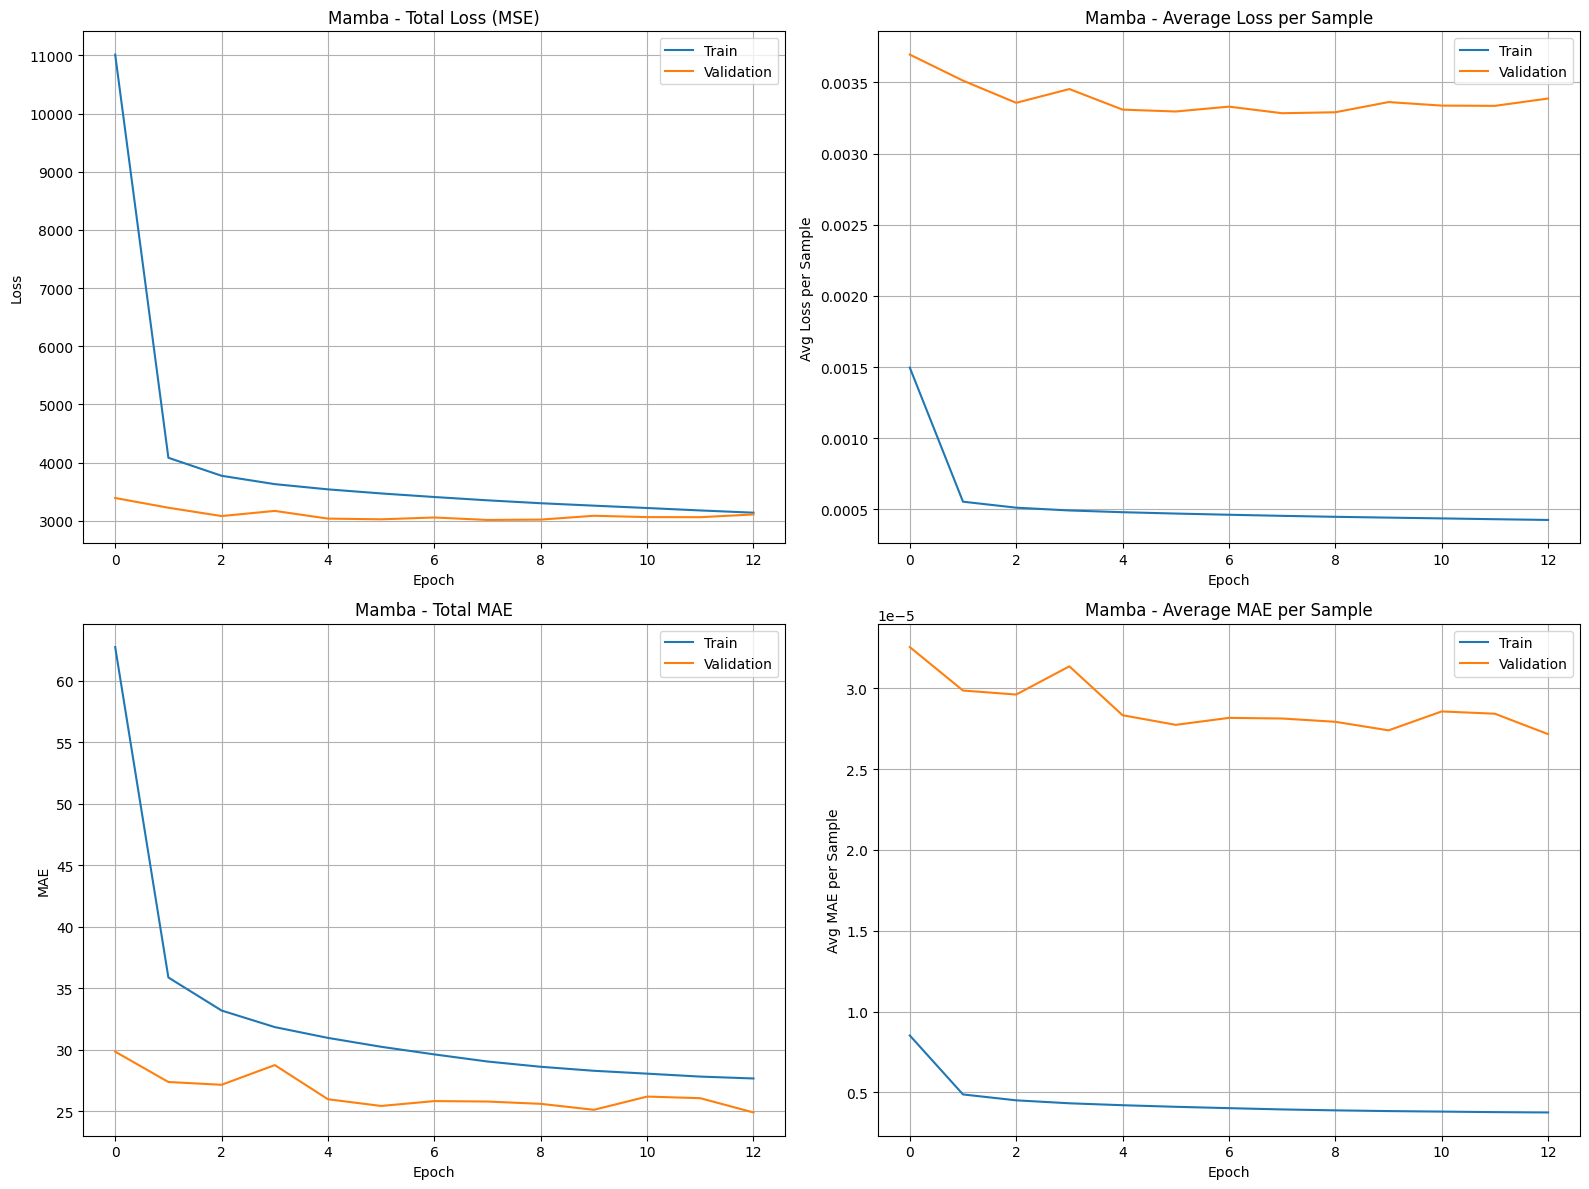


Evaluating Mamba model on test set...



Mamba - Test Evaluation Metrics:
  Overall:  MSE: 2985.12, RMSE: 54.64, MAE: 24.76, R²: 0.9678, MASE: 0.49
  Daytime:  MSE: 5990.00, RMSE: 77.40, MAE: 48.70, R²: 0.9272, MASE: 0.48
  Nighttime: MSE: 2.43, RMSE: 1.56, MAE: 0.99, R²: 0.0671, MASE: 9.72
  Inference Speed: 2774664.18 samples/sec, 0.3604 μs/sample
  Total time: 0.3315 sec for 919800 samples
Model saved to checkpoints/Mamba_best_20250507_084148.pt with metadata.
Best model saved to checkpoints/Mamba_best_20250507_084148.pt
Saved model checkpoint logged to wandb: checkpoints/Mamba_best_20250507_084148.pt


test/inference_speed_samples_per_sec,▁
test/inference_time_us_per_sample,▁
test/mae,▁
test/mase,▁
test/mse,▁
test/r2,▁
test/rmse,▁
train/epoch,▁▂▂▃▃▄▅▅▆▆▇▇█
train/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁
train/loss,█▂▂▁▁▁▁▁▁▁▁▁▁
train/mae,█▃▂▂▂▂▁▁▁▁▁▁▁


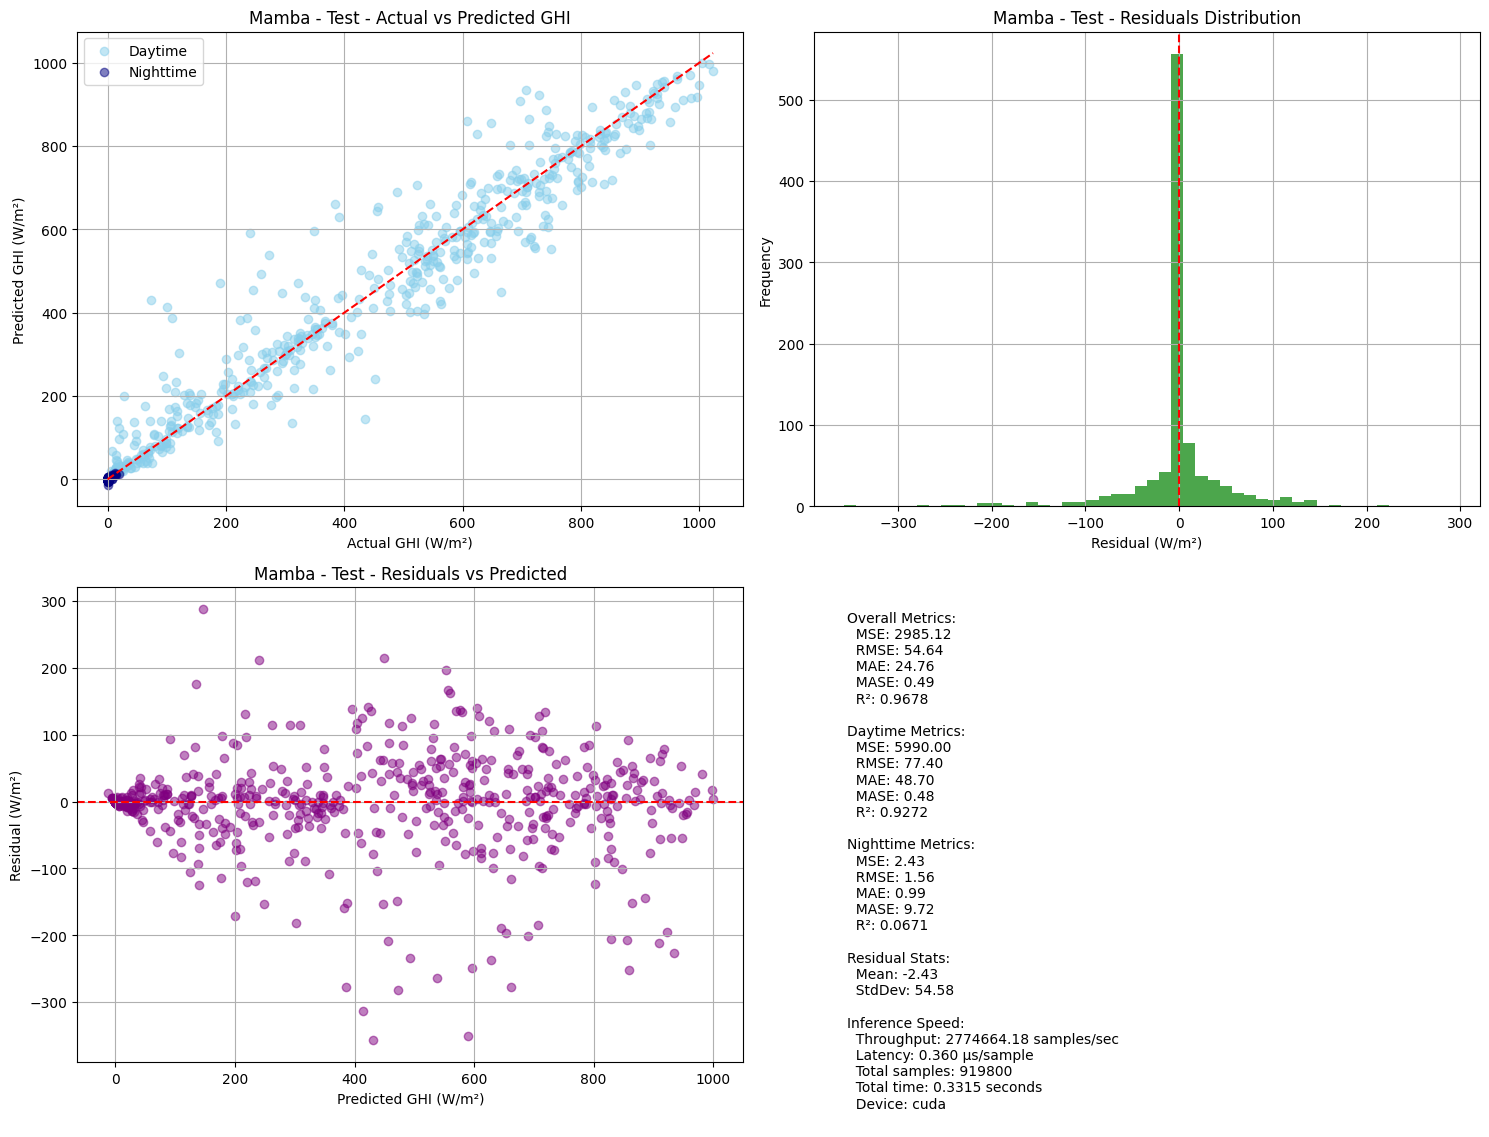

In [17]:
model_name = "Mamba"

# Train the Mamba model
mamba_history, mamba_val_metrics, mamba_test_metrics = run_experiment_pipeline(
    mamba_model,
    train_loader,
    val_loader,
    test_loader,
    model_name=model_name,
    epochs=N_EPOCHS,
    patience=PATIENCE,
    lr=LR
)

## 4. Model Comparison

After training all models, we compare their performance to determine which advanced architecture works best for GHI forecasting.

## 4.1 Compare Advanced Models' Performance

This section compares the overall performance metrics (MSE, RMSE, MAE, MASE, R²) of all trained advanced models
on the test dataset. These metrics help us understand which state-of-the-art model provides the most
accurate predictions across the entire test set.


Model Comparison - Test Set:
              Transformer        Informer         TSMixer   iTransformer  \
MSE           2816.766602     2848.561035     2789.595947    2954.246338   
RMSE            53.073219       53.371912       52.816626      54.352979   
MAE             24.258215       25.114868       24.686117      26.711201   
MASE             0.482233        0.499262        0.490739       0.530996   
R²               0.969569        0.969226        0.969863       0.968084   
Samples/sec  8863261.7822  3750593.826268  4982443.331874  8228370.37214   
μs/sample        0.112825        0.266624        0.200705       0.121531   

                      Mamba  
MSE             2985.122803  
RMSE              54.636277  
MAE                24.75502  
MASE               0.492109  
R²                  0.96775  
Samples/sec  2774664.177617  
μs/sample          0.360404  


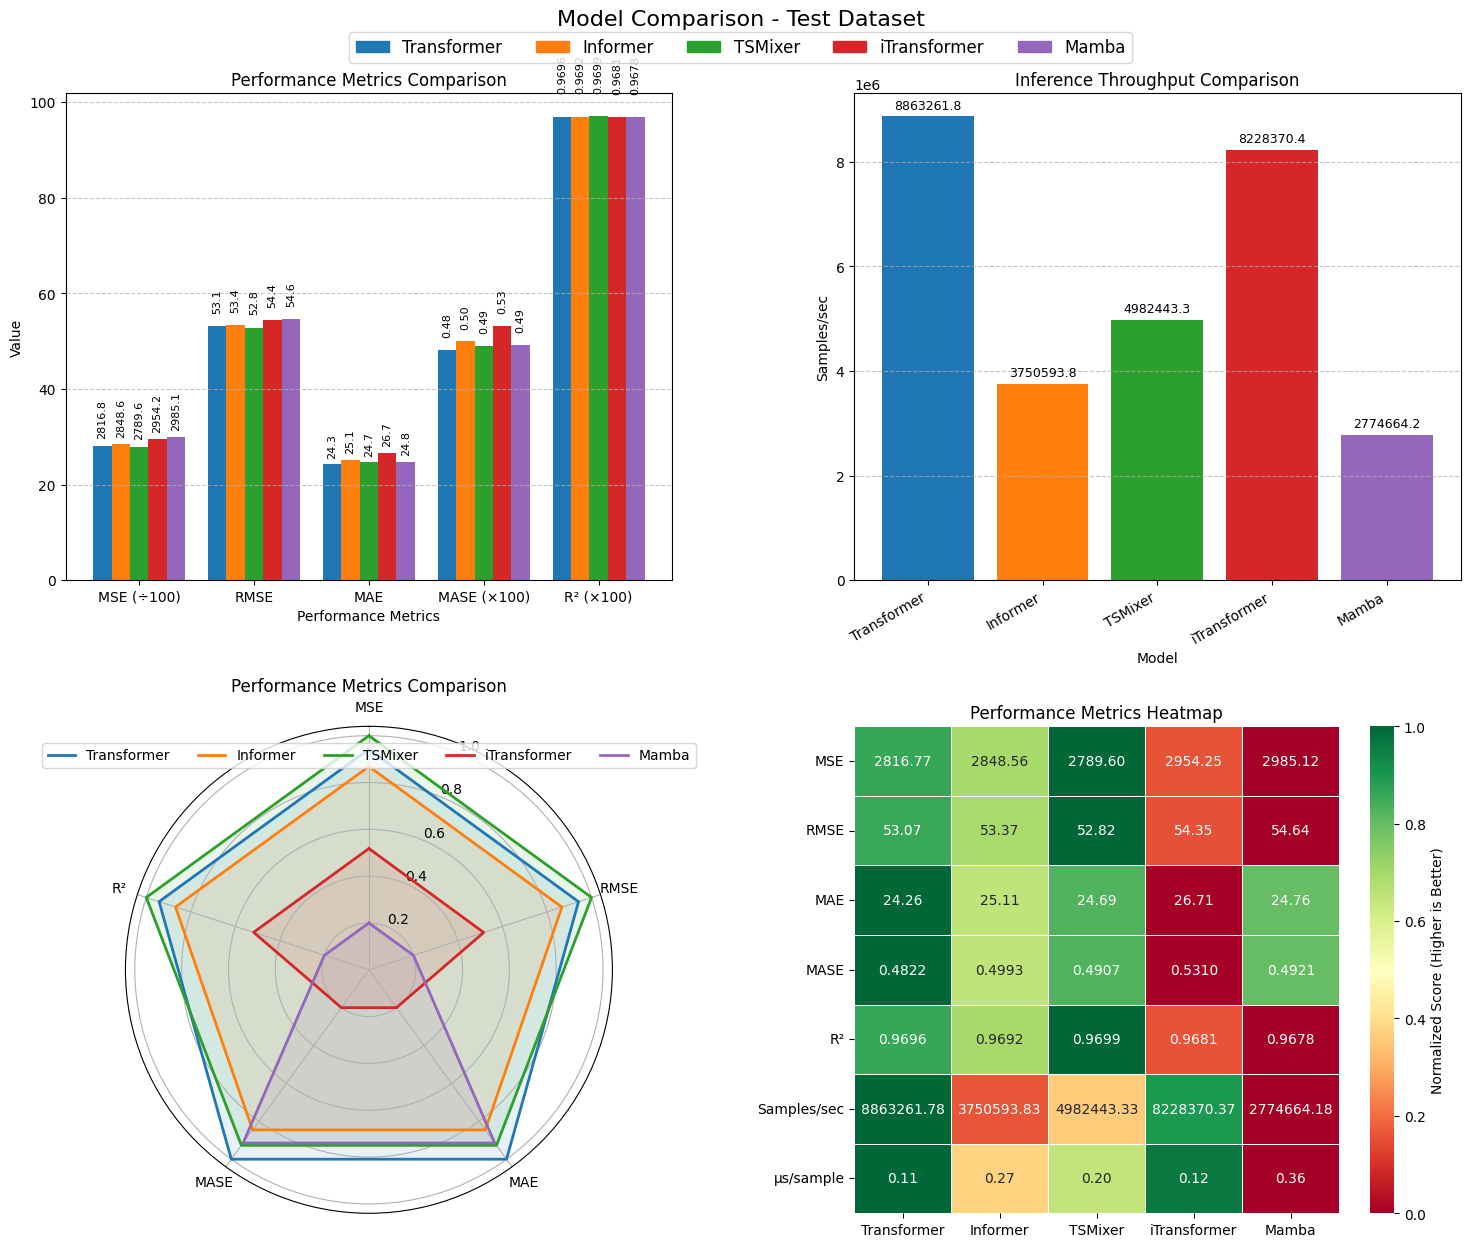

In [18]:
from utils.plot_utils import compare_models

# Create a dictionary of model metrics
model_metrics = {
    'Transformer': transformer_test_metrics,
    'Informer': informer_test_metrics,
    'TSMixer': tsmixer_test_metrics,
    'iTransformer': itransformer_test_metrics,
    'Mamba': mamba_test_metrics
}
# Drop the 'y_pred' and 'y_true' keys from the model metrics
for model in model_metrics:
    model_metrics[model].pop('y_pred', None)
    model_metrics[model].pop('y_true', None)
    model_metrics[model].pop('nighttime_mask', None)

# Save model metrics to a json file for later use
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
json_file_path = f'plots/advanced_model_metrics_{timestamp}.json'
# Fix TypeError: Object of type float32 is not JSON serializable
for model in model_metrics:
    for key, value in model_metrics[model].items():
        if isinstance(value, np.float32):
            model_metrics[model][key] = float(value)
with open(json_file_path, 'w') as f:
    json.dump(model_metrics, f)

# Compare model performance on test set
fig = compare_models(model_metrics, dataset_name='Test')

## 4.2 Model Comparison on Daytime/Nighttime/Overall

Here we analyze model performance separately for daytime and nighttime periods. This is crucial for solar forecasting
as prediction requirements and patterns differ significantly between day and night. The comparison helps identify
which advanced models perform better under different lighting conditions.

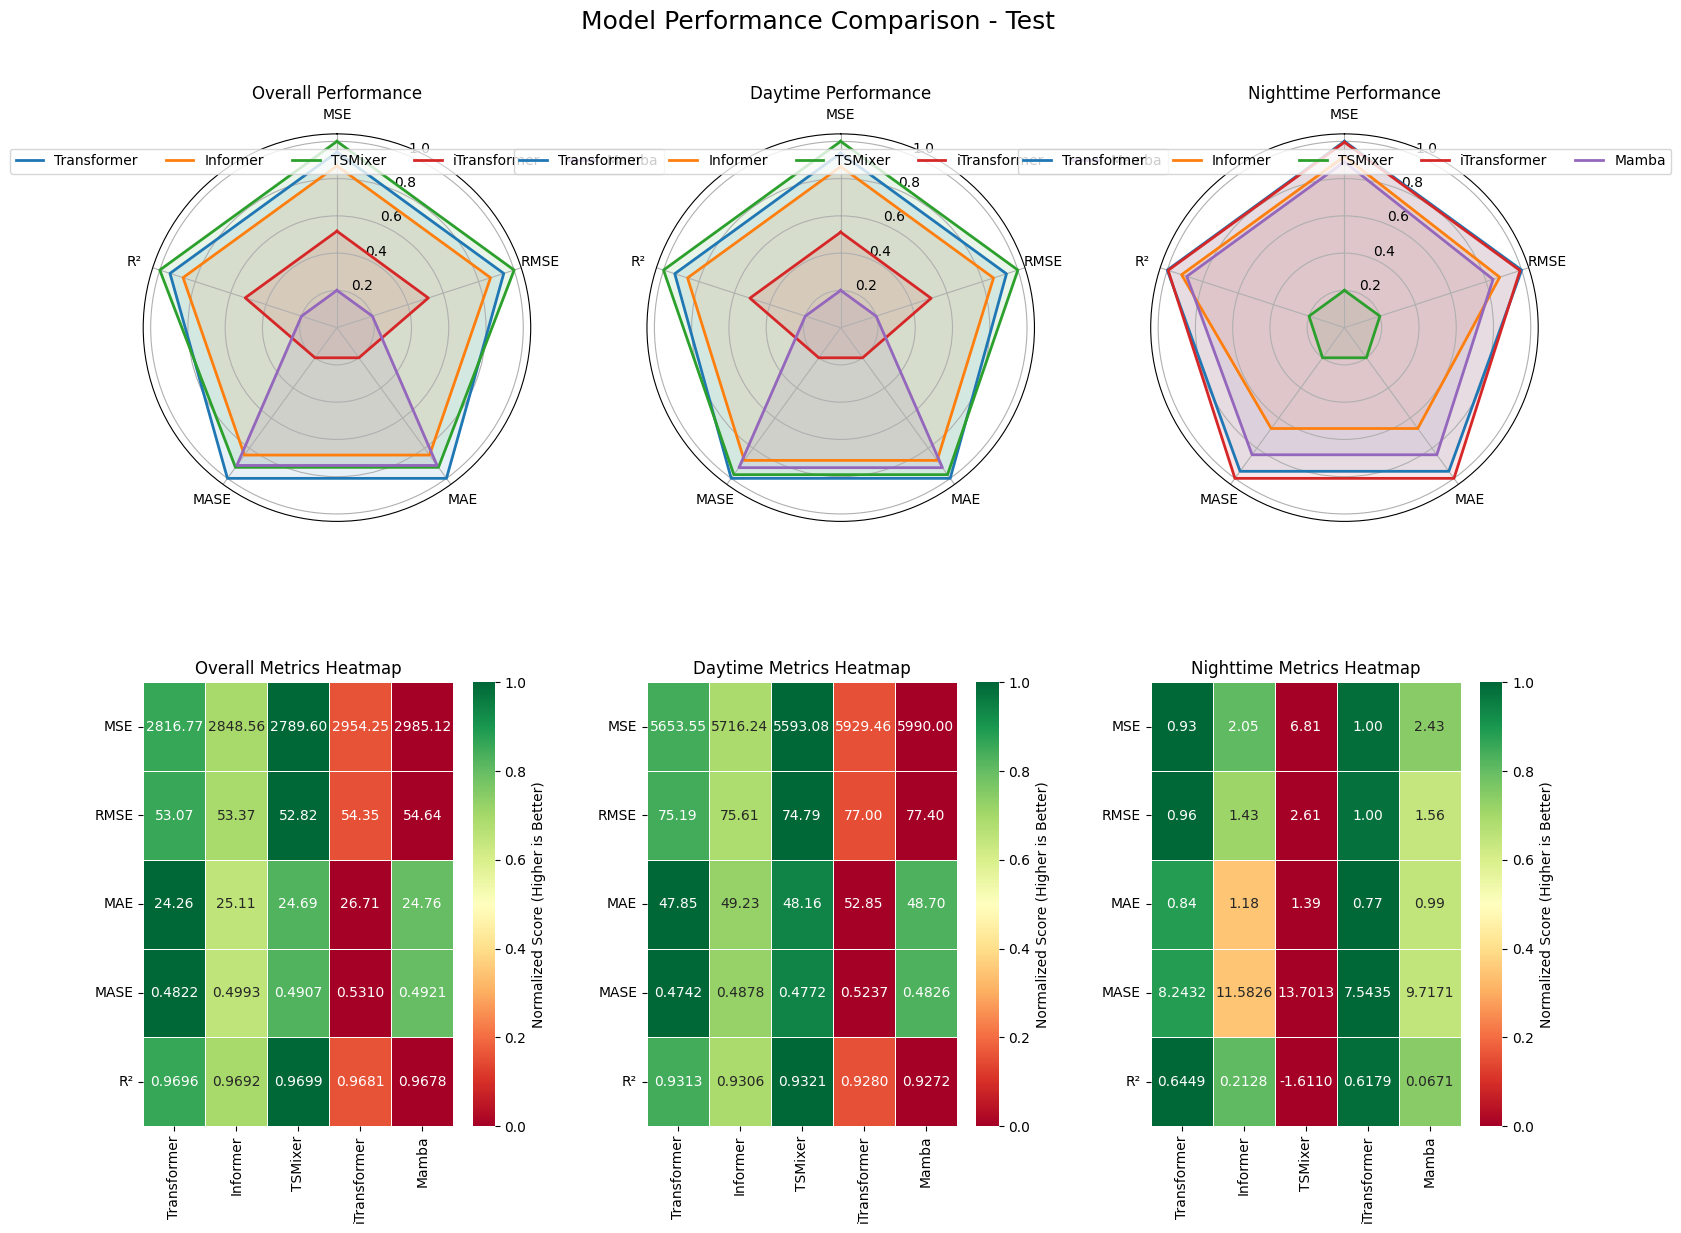

In [19]:
from utils.plot_utils import compare_models_daytime_nighttime

# Generate the comparison plot
comparison_fig = compare_models_daytime_nighttime(model_metrics, dataset_name='Test')

## 5. Visualization and Analysis

This section provides visual analysis of advanced model predictions to better understand model performance.

### 5.1 Time Series Predictions

Visualize predictions over time to compare how each advanced model tracks the actual GHI values. This visualization includes:
- Actual GHI values (ground truth)
- Predictions from each advanced model architecture
- Nighttime periods shaded for context
- Error metrics for the visualized time period

In [20]:
def plot_predictions_over_time(models, model_names, data_loader, target_scaler, num_samples=200, start_idx=0):
    """
    Plot time series predictions for multiple models with nighttime shading if available

    Args:
        models: List of PyTorch models
        model_names: List of model names
        data_loader: Data loader
        target_scaler: Scaler for the target variable
        num_samples: Number of consecutive time steps to plot
        start_idx: Starting index in the dataset
    """
    # Get device
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Collect data samples
    all_batches = []
    for batch in data_loader:
        all_batches.append(batch)
        if len(all_batches) * batch['target'].shape[0] > start_idx + num_samples:
            break

    # Combine batches into a single dataset
    all_temporal = []
    all_static = []
    all_targets = []
    all_nighttime = []
    all_time_index_local = []
    has_nighttime = False
    has_time_index_local = False

    for batch in all_batches:
        all_temporal.append(batch['temporal_features'])
        all_static.append(batch['static_features'])
        all_targets.append(batch['target'])
        # Check if nighttime data is available
        if 'nighttime_mask' in batch:
            has_nighttime = True
            all_nighttime.append(batch['nighttime_mask'])
        # Check if time_index_local is available
        if 'time_index_local' in batch:
            has_time_index_local = True
            # Store the time index values as they are
            if isinstance(batch['time_index_local'], list):
                all_time_index_local.extend(batch['time_index_local'])
            else:
                all_time_index_local.append(batch['time_index_local'])

    all_temporal = torch.cat(all_temporal, dim=0)
    all_static = torch.cat(all_static, dim=0)
    all_targets = torch.cat(all_targets, dim=0)

    if has_nighttime:
        all_nighttime = torch.cat(all_nighttime, dim=0)

    # Get the subset for visualization
    temporal = all_temporal[start_idx:start_idx+num_samples].to(device)
    static = all_static[start_idx:start_idx+num_samples].to(device)
    targets = all_targets[start_idx:start_idx+num_samples].cpu().numpy()

    if has_nighttime:
        nighttime = all_nighttime[start_idx:start_idx+num_samples].cpu().numpy()
        # Ensure nighttime is a 1D array
        if len(nighttime.shape) > 1:
            nighttime = nighttime.flatten() if nighttime.shape[1] == 1 else nighttime[:,0]

    # Get time index for x-axis if available
    x_values = None
    if has_time_index_local and len(all_time_index_local) >= start_idx + num_samples:
        # Extract the time values for the plotting window
        x_values = all_time_index_local[start_idx:start_idx+num_samples]

        # Try to convert to datetime objects if they are strings
        if isinstance(x_values[0], str):
            try:
                # Try different datetime formats
                date_formats = ['%Y-%m-%d %H:%M:%S', '%Y-%m-%d %H:%M', '%Y-%m-%dT%H:%M:%S', '%Y%m%d%H%M%S']
                for date_format in date_formats:
                    try:
                        x_values = [datetime.strptime(t, date_format) for t in x_values]
                        print(f"Successfully parsed dates with format: {date_format}")
                        break
                    except ValueError:
                        continue

                # If we couldn't parse with any format, notify and use indices
                if isinstance(x_values[0], str):
                    print(f"Could not parse date format: {x_values[0]}, using indices instead")
                    x_values = None

            except (ValueError, TypeError) as e:
                # If conversion fails, fall back to using indices
                print(f"Error converting time_index_local to datetime: {e}, using indices instead")
                x_values = None

    # Generate predictions
    predictions = []
    for model in models:
        model.eval()
        with torch.no_grad():
            outputs = model(temporal, static).cpu().numpy()
            predictions.append(outputs)

    # Inverse transform to original scale
    y_true_orig = target_scaler.inverse_transform(targets.reshape(-1, 1)).flatten()
    y_pred_orig_list = [target_scaler.inverse_transform(pred.reshape(-1, 1)).flatten() for pred in predictions]

    # Create visualization
    fig = plt.figure(figsize=(15, 8))
    ax = plt.gca()

    # Define colors and line styles for predictions
    colors = ['blue', 'red', 'green', 'magenta', 'cyan', 'orange']
    line_styles = ['--', ':', '-.', '--', ':', '--']

    # Set x-axis values based on availability of time_index_local
    if x_values:
        # Plot actual values with time index
        actual_line, = plt.plot(x_values, y_true_orig, 'k-', label='Actual GHI', linewidth=2)

        # Plot predictions with time index
        pred_lines = []
        handles = [actual_line]
        labels = ['Actual GHI']

        for i, (pred, name) in enumerate(zip(y_pred_orig_list, model_names)):
            color = colors[i % len(colors)]
            style = line_styles[i % len(line_styles)]
            line, = plt.plot(x_values, pred, color=color, linestyle=style, label=f'{name} Predicted', alpha=0.7)
            pred_lines.append(line)
            handles.append(line)
            labels.append(f'{name} Predicted')

        # Format the x-axis to show dates properly
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%M'))
        plt.xticks(rotation=0)  # Make labels horizontal
        fig.subplots_adjust(bottom=0.15)  # Adjust bottom margin for horizontal labels

        # If we have nighttime data, shade those regions
        if has_nighttime:
            # Modify nighttime shading to work with datetime x-axis
            nighttime_bool = (nighttime > 0.5)
            night_regions = []
            start = None
            for i, is_night in enumerate(nighttime_bool):
                if is_night and start is None:
                    start = i
                elif not is_night and start is not None:
                    night_regions.append((start, i))
                    start = None
            if start is not None:
                night_regions.append((start, len(nighttime_bool)))

            for start, end in night_regions:
                if start < len(x_values) and end <= len(x_values):
                    ax.axvspan(x_values[start], x_values[min(end, len(x_values)-1)],
                              alpha=0.2, color='gray', label='_nolegend_')
    else:
        # Use default integer indices for x-axis
        actual_line, = plt.plot(y_true_orig, 'k-', label='Actual GHI', linewidth=2)

        # Plot predictions and collect handles/labels
        pred_lines = []
        handles = [actual_line]
        labels = ['Actual GHI']

        for i, (pred, name) in enumerate(zip(y_pred_orig_list, model_names)):
            color = colors[i % len(colors)]
            style = line_styles[i % len(line_styles)]
            line, = plt.plot(pred, color=color, linestyle=style, label=f'{name} Predicted', alpha=0.7)
            pred_lines.append(line)
            handles.append(line)
            labels.append(f'{name} Predicted')

        # If we have nighttime data, shade those regions
        if has_nighttime:
            nighttime_bool = (nighttime > 0.5)
            night_regions = []
            start = None
            for i, is_night in enumerate(nighttime_bool):
                if is_night and start is None:
                    start = i
                elif not is_night and start is not None:
                    night_regions.append((start, i))
                    start = None
            if start is not None:
                night_regions.append((start, len(nighttime_bool)))

            for start, end in night_regions:
                ax.axvspan(start, end, alpha=0.2, color='gray', label='_nolegend_')

    # Add nighttime legend if applicable
    if has_nighttime and len(night_regions) > 0:
        night_patch = Patch(facecolor='gray', alpha=0.2, label='Nighttime')
        handles.append(night_patch)
        labels.append('Nighttime')

    # Calculate and display error metrics for the visualization window
    for i, (pred, name) in enumerate(zip(y_pred_orig_list, model_names)):
        rmse = np.sqrt(np.mean((y_true_orig - pred) ** 2))
        mae = np.mean(np.abs(y_true_orig - pred))
        plt.annotate(f"{name}: RMSE={rmse:.2f}, MAE={mae:.2f}",
                     xy=(0.02, 0.97 - 0.03*i),
                     xycoords='axes fraction',
                     fontsize=9,
                     bbox=dict(boxstyle="round,pad=0.3", fc="white", alpha=0.8))

    plt.title('GHI Predictions Over Time')
    plt.xlabel('Time' if x_values else 'Time Step')
    plt.ylabel('GHI (W/m²)')

    # Set the legend with the correct handles and labels
    plt.legend(handles, labels, loc='upper right')

    plt.grid(True)
    plt.tight_layout()
    # Save the figure
    os.makedirs('plots', exist_ok=True)
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    plt.savefig(f'plots/predictions_over_time_{timestamp}.png')
    return fig

Successfully parsed dates with format: %Y-%m-%dT%H:%M:%S


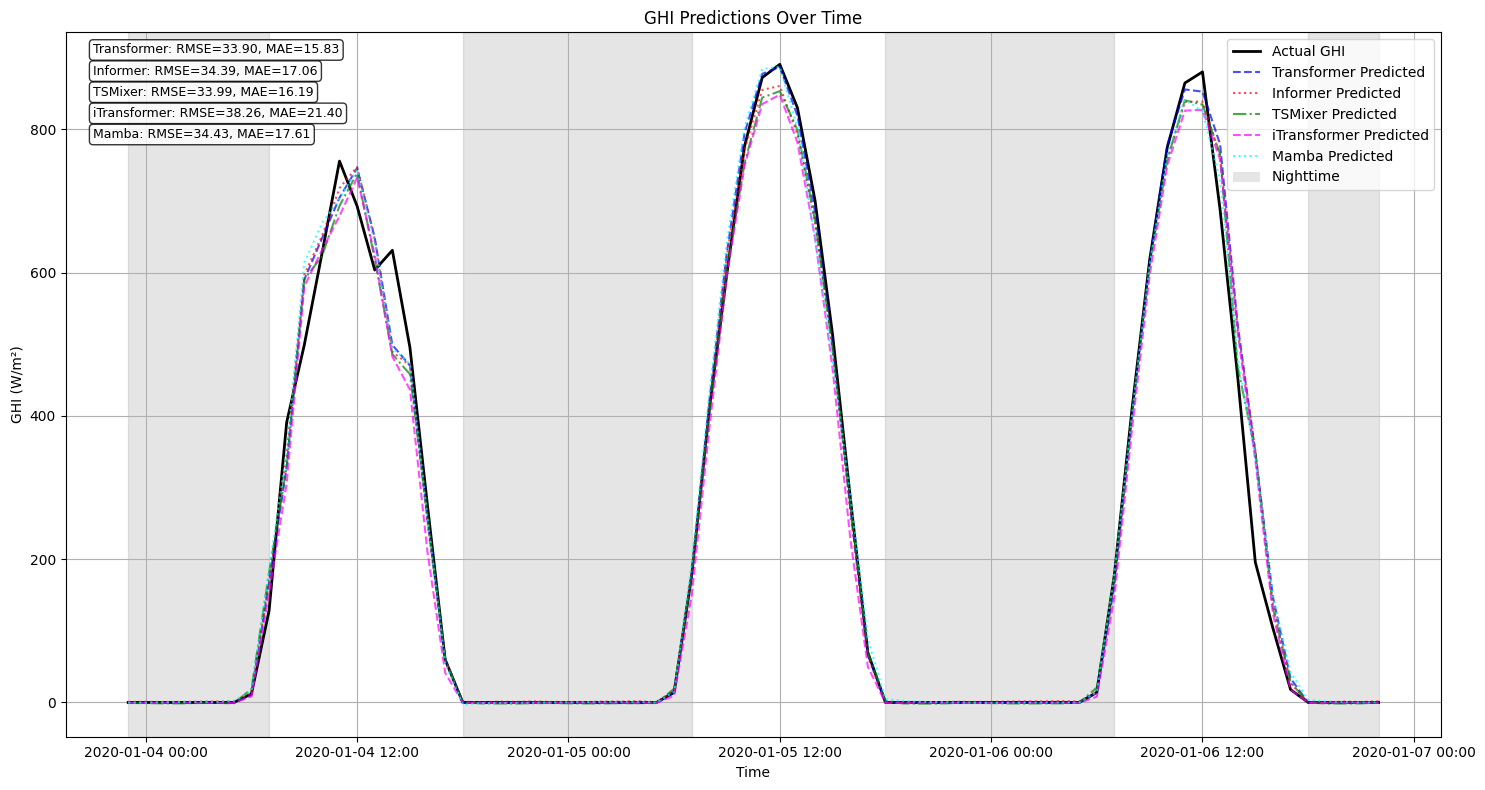

In [21]:
# Plot time series predictions for advanced models
_ = plot_predictions_over_time(
    models=[transformer_model, informer_model, tsmixer_model, itransformer_model, mamba_model],
    model_names=['Transformer', 'Informer', 'TSMixer', 'iTransformer', 'Mamba'],
    data_loader=test_loader,
    target_scaler=scalers[f'{TARGET_VARIABLE}_scaler'],
    num_samples=72,
    start_idx=40
)